# <center> PHAS0020: Final Python Task: Didymos Investigation
    
<i> Notebook author: 22007185

<i> Submission deadline: 4 March 2024

## Introduction

The main focus of this notebook is an investigation into the asteroid of Didymos. The magnitude of the Didymos system was calculated to be 12.92 $\pm$ 0.08, which is in agreement with the calculated value by A. Graykowski _et al._ of $m_v$ = 12.96 $\pm$ 0.04, for a similar time of observation, once the fast-moving ejecta was no longer in the aperture <a href="https://www.nature.com/articles/s41586-023-05852-9">[1]</a>.  

To obtain this magnitude, I first performed aperture photometry ab initio on 10 reference stars chosen arbitrarily in one of the provided frames, to be able to linearly calibrate magnitude and counts. The process of aperture photometry was then rerun on three more frames, in order to compile a mean flux trend curve over time. This allowed for detrending of the fluxes obtained from aperture photometry. Using this trend, it was possible to calculate a mean flux for Didymos to use in the earlier linear calibration to lead to an interpolated magnitude of Didymos.  

In addition to aperture photometry, the angular velocity of Didymos was calculated as 0.105 $\pm$ 1.411 $^{\circ}$/hr. The recorded value from the JPL Ephemeris service <a href="https://ssd.jpl.nasa.gov/horizons/app.html#/">[2]</a> is 0.107 $^{\circ}$/hr, which is a 2% difference to the calculated value. This was achieved by doing linear fits to both RA and Dec.    

Finally, I investigated briefly the trail from Dimorphos - a smaller asteroid in orbit around Didymos - of which the trail was caused by NASA's DART mission. I conducted aperture photometry using an elliptical aperture, which led to a calculation of flux of 140 $\pm$ 30 ADUs/arcsec.

$$-*-$$

First, we import the necessary libraries for the task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize

#To introduce a range of 3D plots
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#to load images
import astropy
from astropy.io import fits
#to obtain time array
import datetime as dt
#tables (simply for visuals)
from tabulate import tabulate

# The following line makes the images a bit larger than default - works better on a large screen
plt.rcParams['figure.figsize'] = 15,12

## Task A: Preparation

Task A is about preparing functions necessary later on: an aperture photometry function, an image importing function, a header loading function, and a couple image plotting functions to aid in visualisation.

### A1: Aperture photometry function

First, the aperture photometry function.  

Of note is the calculation of flux (and corresponding uncertainty). For the flux, the standard equation given in Task 4 was used:

$$ \tag{1} Flux = \Sigma _{pixel \in circle} Image(pixel) - N_{pixel \in circle} \cdot Median(pixels \in Ring)$$

For the errors, I took the error in the aperture to be due to the Poissonian nature of the counts, and so the square root of the flux was taken. For the error in the annulus, I used the standard error of the median:

$$   \tag{2} SE_{med} \simeq 1.253 \cdot \frac{\sigma}{\sqrt{n}} $$ 

for standard deviation $\sigma$ and sample size $n$ <a href="https://en.wikipedia.org/wiki/Median#Efficiency">[3]</a>. The factor of $ (\pi / 2)^{1/2} \simeq 1.253 $ is due to comparison to the standard error of the mean <a href="https://en.wikipedia.org/wiki/Median#Efficiency">[3]</a>.

Finally, adding these two estimates in quadrature results in an uncertainty in the total flux.

In [2]:
### adapted from my Task 4 submission into a function ###
def ap(subset, r, x0, y0):
    """
    Performs aperture photometry on the given subset (or full image), using:
    subset: input data
    r: radius of aperture
    x0: horizontal position (in pixels) of centre of object*
    y0: vertical position (in pixels) of centre of object*
    
        *these positions are in the subset, not the full image
        
    The function returns the aperture mask, annulus mask and calculated flux.
    """
    size=np.shape(subset)[0]

    # The following creates a size^2 array from "0" to "size" and then rearranges it 
    # so it's counting along columns and then up 1 row at a time
    temp = np.linspace(0,size,size*size)

    # We then use the "reshape" command to rearrange this long 1D array of values to make a square array
    temp2 = np.reshape(temp,(size,size))

    # Now we use the raster scan array obtained to create two arrays which are respectively the "x" and the "y" of 
    # any 2D square image we want with "size" as its side.

    yy = np.floor(temp2)     # floor truncates the array (as pixel values are integers)
    temp3 = size*(temp2-yy)
    xx = np.floor(temp3)
    
    
    #radius of aperture as function
    radius1 = np.sqrt((xx-x0)**2 + (yy-y0)**2)

    #mask as radius function limited to below r defined above
    mask1 = radius1 <= r
    
    #annulus, so defined as between two radii
    mask2 = (radius1 >= r+1)&(radius1<=2*r)
    
    #locations of values within annulus
    non0mask2 = np.where(subset*mask2>0)
    #data from within annulus
    annulus_data = subset[non0mask2]

    median = np.median(annulus_data)

    #flux using eqn 1
    flux = np.sum(subset*mask1) - np.sum(mask1) * median
    
    #aperture error can be approximated as sqrt(flux) due to Poissonian nature
    err_ap = np.sqrt(flux)
    #annulus error is found using the standard error of median; eqn 2
    err_an = 1.253*np.std(annulus_data)/np.sqrt(len(annulus_data))
    
    err_flux = np.sqrt(err_ap**2 + err_an**2)
    
    return mask1, mask2, flux, err_flux

### A2: Image & header importing functions

Next are some importing functions. The `head_load()` function will be particularly useful later when calculating the coordinates of reference stars and Didymos. The functions `quickplot()` and `quicksubplot()` are also useful later, when plotting the <tt> .fits </tt> files.

In [3]:
### adapted from provided cells in Task 4 ###
def img_load(name):
    """
    Returns the image data and image header, given the file name.
    (The file must be in the same folder as this notebook)
    """
    image = fits.open(name)
    image_head=image[0].header
    image_data=image[0].data
    image.close()
    
    return image_data, image_head

def head_load(head):
    """
    Returns the RA, Dec, exp time, ref pixel coordinates and pixel scale
    of the image, given the header.
    """
    #Assign reference values for RA and DEC...
    ref_RA   = head['CRVAL1']
    ref_DEC  = head['CRVAL2']
    #...to reference pixels for RA and DEC
    refpix_RA = head['CRPIX1']
    refpix_DEC = head['CRPIX2']

    #Now we know an "origin" to our reference frame. We need a "scale"... how much RA and DEC for each pixel
    d_RA  = head['CD1_1']
    d_DEC = head['CD2_2']
    
    exp_t = head['EXPTIME']
    
    return ref_RA, ref_DEC, refpix_RA, refpix_DEC, d_RA, d_DEC, exp_t


### from 'PHAS0020-S0c-JupyterN_PHAS0003-refresh.ipynb', S. Fossey et al. [4] ###
## display an image as greyscale ##
def quickplot(input_image, xlo, xhi):
    displo = np.median(input_image)-xlo*np.std(input_image)
    disphi= np.median(input_image)+xhi*np.std(input_image)
    plt.imshow(input_image, cmap='gray',vmin=displo,vmax=disphi)
   
 #adapted from above function to fit subplots#
def quicksubplot(input_image, xlo, xhi,row,column):
    displo = np.median(input_image)-xlo*np.std(input_image)
    disphi= np.median(input_image)+xhi*np.std(input_image)
    ax[row,column].imshow(input_image, cmap='gray',vmin=displo,vmax=disphi)

## Task B: Reference stars analysis

### B1: Astrometry of reference stars

First of all in this section, I chose the third image in the zip file to use. After plotting to get a grasp of how it looks, I estimated coordinates of arbitrary stars to use as references. I tried my best to get a range in magnitudes based on visuals, however I had issues locating lots of the dimmer stars in SIMBAD, and those that were able to be located resulted in odd values in Task C. The coordinates were found by using a symmetrical letter first (such as o) which would be easier to line up more accurate coordinates. These were then labelled A through J. Of note is a second g, as the first one had fluxes varying by up to 50% its maximum across four frames, and so was changed. This star is also labelled.

Text(1070, 1395, 'j')

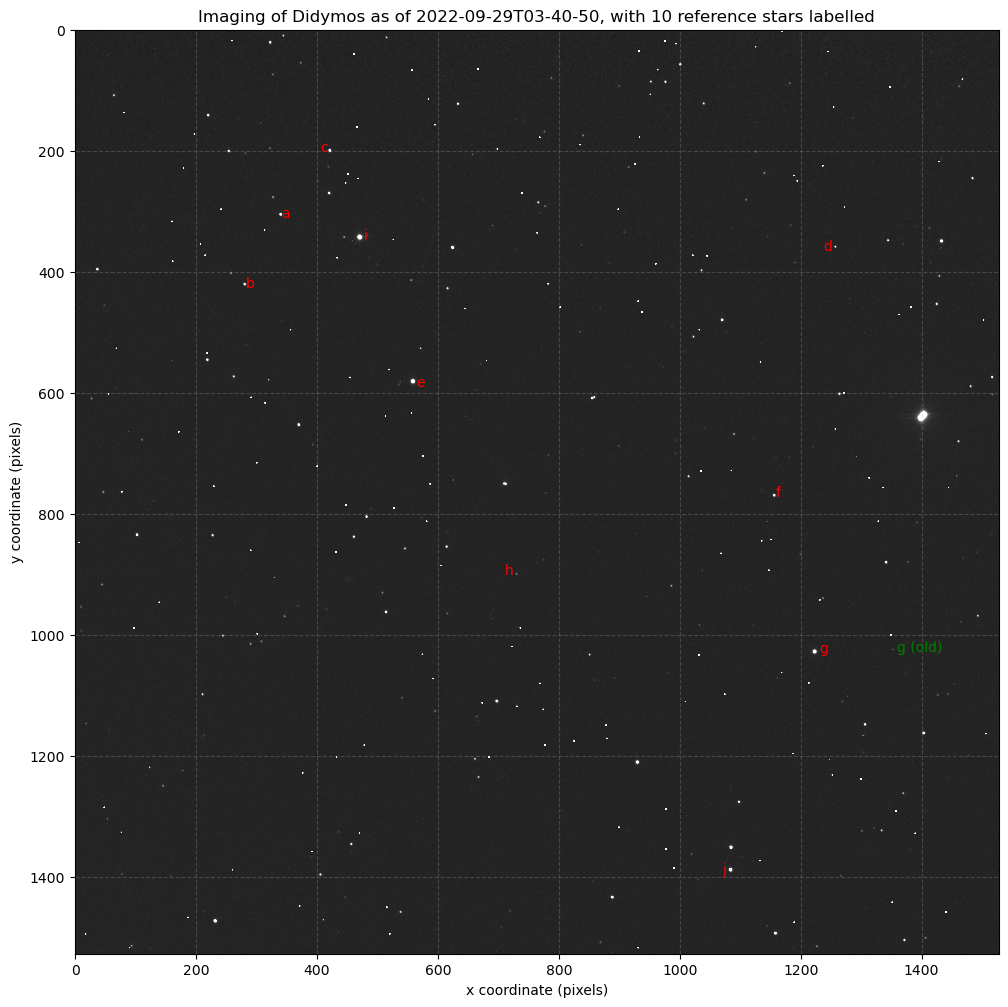

In [4]:
data1, head1 = img_load('./2022-09-29T03-40-50_Didymos_Red_T-25_60s_cal.fits')

quickplot(data1,0.5,3)
plt.title('Imaging of Didymos as of 2022-09-29T03-40-50, with 10 reference stars labelled')
plt.grid(linestyle='--', alpha=0.25)
plt.xlabel("x coordinate (pixels)")
plt.ylabel("y coordinate (pixels)")

# identification of 10 stars, labelled a to j
xa,ya = [343,305]
plt.text(340,310,"a",color='r')
xb,yb = [283,420]
plt.text(283,425,"b",color='r')
xc,yc = [418,200]
plt.text(405,200,"c",color='r')
xd,yd = [1257,360]
plt.text(1237,365,"d",color='r')
xe,ye = [560,580]
plt.text(565,590,"e",color='r')
xf,yf = [1158,770]
plt.text(1159,771,"f",color='r')
xg_OLD,yg_OLD = [1353,1023]               # initial choice for g yielded large flux
plt.text(1359,1027,"g (old)",color='g')   # variances over several images so changed
xg,yg = [1220,1027]
plt.text(1230,1030,"g",color='r')
xh,yh = [730,900]
plt.text(710,900,"h",color='r')
xi,yi = [470,343]
plt.text(478,347,"i",color='r')
xj,yj = [1085,1390]
plt.text(1070,1395,"j",color='r')

<center> Fig. 1: Imaging of Didymos as of 2022-09-29T03-40-50, with 10 reference stars labelled  </center>
    

To be able to locate these reference stars, I created a function to easily translate the coordinates from pixels to RA and Dec.

In [5]:
### adapted from my Task 4 submission ###

def pix2cel(xx,yy,head):
    """
    Converts the input pixel coordinates to celestial coordinates (RA, Dec), given the image header
    xx: x coordinate
    yy: y coordinate
    head: header from .fits image file
    """
    #using function defined in A2 to retrieve relevant header data
    ref = head_load(head)

    # calculating ra,dec in degrees by conversion from pixels
    ra = (xx - ref[2]) * ref[4] + ref[0]

    dec = (yy - ref[3]) * ref[5] + ref[1]
    
    return ra,dec

#formatting coords as arrays to use loops later
x_10 = np.array([xa,xb,xc,xd,xe,xf,xg,xh,xi,xj])
y_10 = np.array([ya,yb,yc,yd,ye,yf,yg,yh,yi,yj])

#array of letters for easy looping
a2j = ["a","b","c","d","e","f","g","h","i","j"]

ra,dec = pix2cel(x_10,y_10,head1)

print("COORDINATES OF CHOSEN OBJECTS A to J:")
for i in range(len(ra)):
    print(f"{a2j[i]}: {ra[i]}, {dec[i]}")

COORDINATES OF CHOSEN OBJECTS A to J:
a: 57.53965187154445, -31.6609301332772
b: 57.56032028469295, -31.7005305119829
c: 57.51381635510883, -31.6247732657633
d: 57.2248030445823, -31.6798694448321
e: 57.46490111065738, -31.7556266910517
f: 57.25890592627733, -31.8210534036959
g: 57.237548566023875, -31.90955164132516
h: 57.40634060673663, -31.8658190491893
i: 57.49590373038013, -31.67401547580604
j: 57.284052495608, -32.0345510975875


Having now located 10 stars, I first took to SIMBAD to try and locate them. However, I was having some difficulties so opted to switch to AladinLite, which I found was more user-friendly due to being able to interact and move across the sky. All the magnitudes below were in the Red filter.

In [6]:
# finding magnitudes and errors (R band) using AladinLite
# https://aladin.cds.unistra.fr/AladinLite/ [5] -
# I found using the Gaia database on AladinLite Sky Atlas
# much easier due to its interactivity

mag_a = 12.454252
err_ma = 0.016199
mag_b = 13.226707
err_mb = 0.003817
mag_c = 12.378011
err_mc = 0.003819
mag_d = 14.100035
err_md = 0.004001
mag_e = 10.290331
err_me = 0.003792
mag_f = 13.004393
err_mf = 0.003816
#mag_g = 15.984856      # original g changed -
#err_mg = 0.005161      # perhaps too faint
mag_g = 10.807182
err_mg = 0.003799
mag_h = 15.086635
err_mh = 0.004164
mag_i = 9.404403
err_mi = 0.003788
mag_j = 11.323950
err_mj = 0.003795

mag_10 = [mag_a,mag_b,mag_c,mag_d,mag_e,mag_f,mag_g,mag_h,mag_i,mag_j]
err_m_10 = [err_ma,err_mb,err_mc,err_md,err_me,err_mf,err_mg,err_mh,err_mi,err_mj]

print("MAGNITUDES FOR CHOSEN OBJECTS A to J:")
for i in range(len(mag_10)):
    print(f"{a2j[i]}: {mag_10[i]} +- {err_m_10[i]}")

MAGNITUDES FOR CHOSEN OBJECTS A to J:
a: 12.454252 +- 0.016199
b: 13.226707 +- 0.003817
c: 12.378011 +- 0.003819
d: 14.100035 +- 0.004001
e: 10.290331 +- 0.003792
f: 13.004393 +- 0.003816
g: 10.807182 +- 0.003799
h: 15.086635 +- 0.004164
i: 9.404403 +- 0.003788
j: 11.32395 +- 0.003795


### B2: Aperture Photometry

Next, I needed to use my previously defined aperture photometry function `ap()` to perform aperture photometry on all 10 reference stars found above. Initially, some fluxes had abnormal uncertainties which were due to inaccuracies when finding the pixel coordinates above. To check the coordinates, I overlayed all 10 apertures and annuli onto the frame to ensure they lined up. _(see second code cell below)_

In [7]:
print("FLUXES FOR CHOSEN OBJECTS A to J:")

# radius of 10 - large enough to not lose any flux
# from the star without lots of background for dimmer ones
r = 10
#empty arrays
flux_10 = np.zeros(10)
err_f_10 = np.zeros(10)

#loop to perform AP on each star
for i in range(len(x_10)):
    flux = ap(data1, r, x_10[i], y_10[i])[2]
    flux_10[i] = flux_10[i] + flux
    
    err_f = ap(data1, r, x_10[i], y_10[i])[3]
    err_f_10[i] = err_f_10[i] + err_f

    print(f"{a2j[i]}: {flux_10[i]:.0f} +- {err_f_10[i]:.0f} ADUs")

FLUXES FOR CHOSEN OBJECTS A to J:
a: 66761 +- 258 ADUs
b: 39992 +- 200 ADUs
c: 80381 +- 284 ADUs
d: 16476 +- 128 ADUs
e: 519160 +- 721 ADUs
f: 50187 +- 224 ADUs
g: 431159 +- 657 ADUs
h: 6177 +- 79 ADUs
i: 780470 +- 883 ADUs
j: 242400 +- 492 ADUs


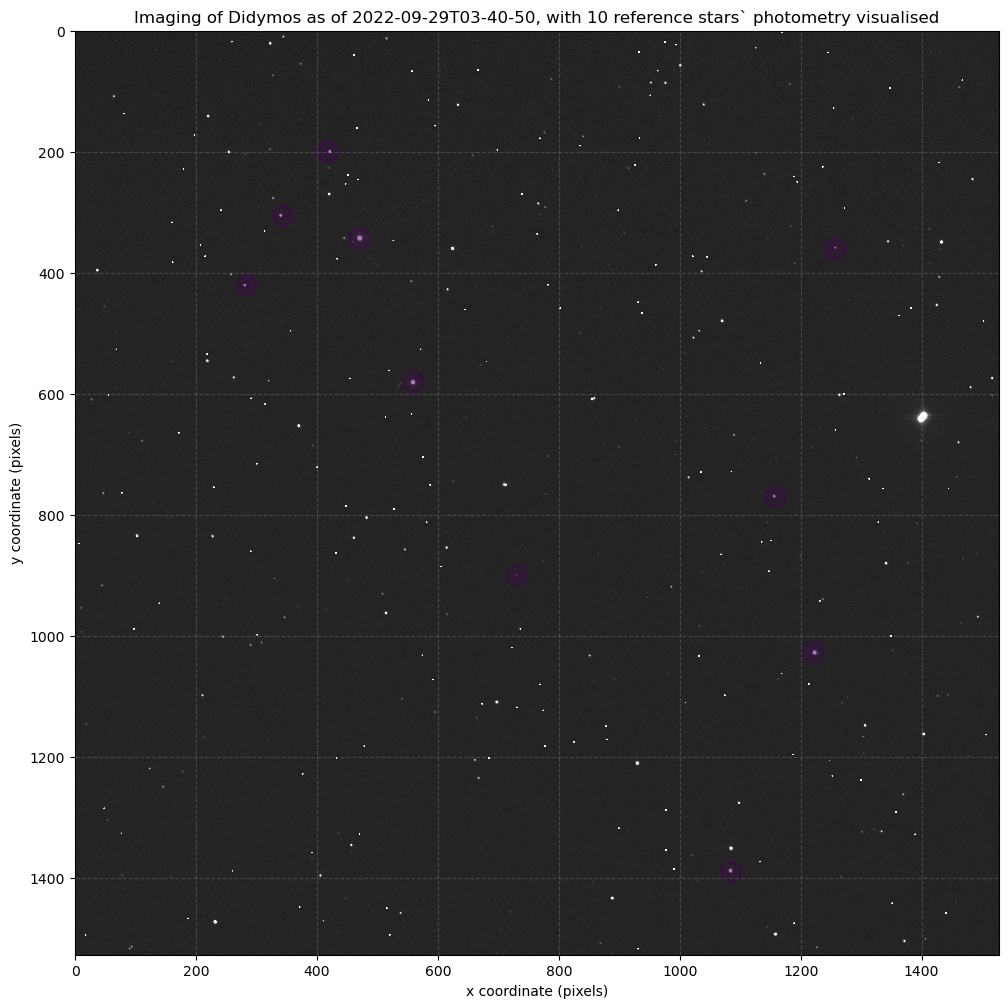

In [8]:
# just for a sanity check - plotting the apertures/annuli around all 10 stars
# to check that they fit within the aperture and there are no nearby stars in the annulus
quickplot(data1,0.5,3)
plt.title('Imaging of Didymos as of 2022-09-29T03-40-50, with 10 reference stars` photometry visualised')
plt.grid(linestyle='--', alpha=0.25)
plt.xlabel("x coordinate (pixels)")
plt.ylabel("y coordinate (pixels)")

for i in range(len(a2j)):
    ap_test_all = ap(data1, r, x_10[i], y_10[i])[0]
# 'np.ma.masked_where' masks all values that meet a given condition (=0 in this case)
# for more pleasant visuals - just plotting ap_test_all (the apertures) for all 10 stars would
# result in the background overlaying 9 times on each star making it hard to see
    ap_test = np.ma.masked_where(ap_test_all==0, ap_test_all)
    
#repeat for annuli
    ann_test_all = ap(data1, r, x_10[i], y_10[i])[1]
    ann_test = np.ma.masked_where(ann_test_all==0, ann_test_all)
    
    plt.imshow(ap_test, alpha=0.5)
    plt.imshow(ann_test, alpha=0.5)


<center> Fig. 2: Imaging of Didymos as of 2022-09-29T03-40-50, with 10 reference stars` photometry visualised  </center>

### B3: Relative Calibration

To plot log(counts) v. magnitude, the errors from part B2 must be propagated correctly. To do this, I used the derivative of $\log_{10}x$ with respect to $x$, resulting in an uncertainty of

$$\tag{3} \Delta\log_{10}x = \frac{\Delta x}{x\ln 10} $$

Having correctly propagated the errors, a straight line fit will be made to the data.

Note: the error bars are too small to display but are coded.

Slope = -0.3242 +- 0.0003
log(counts) axis intercept = 9.011 +- 0.003


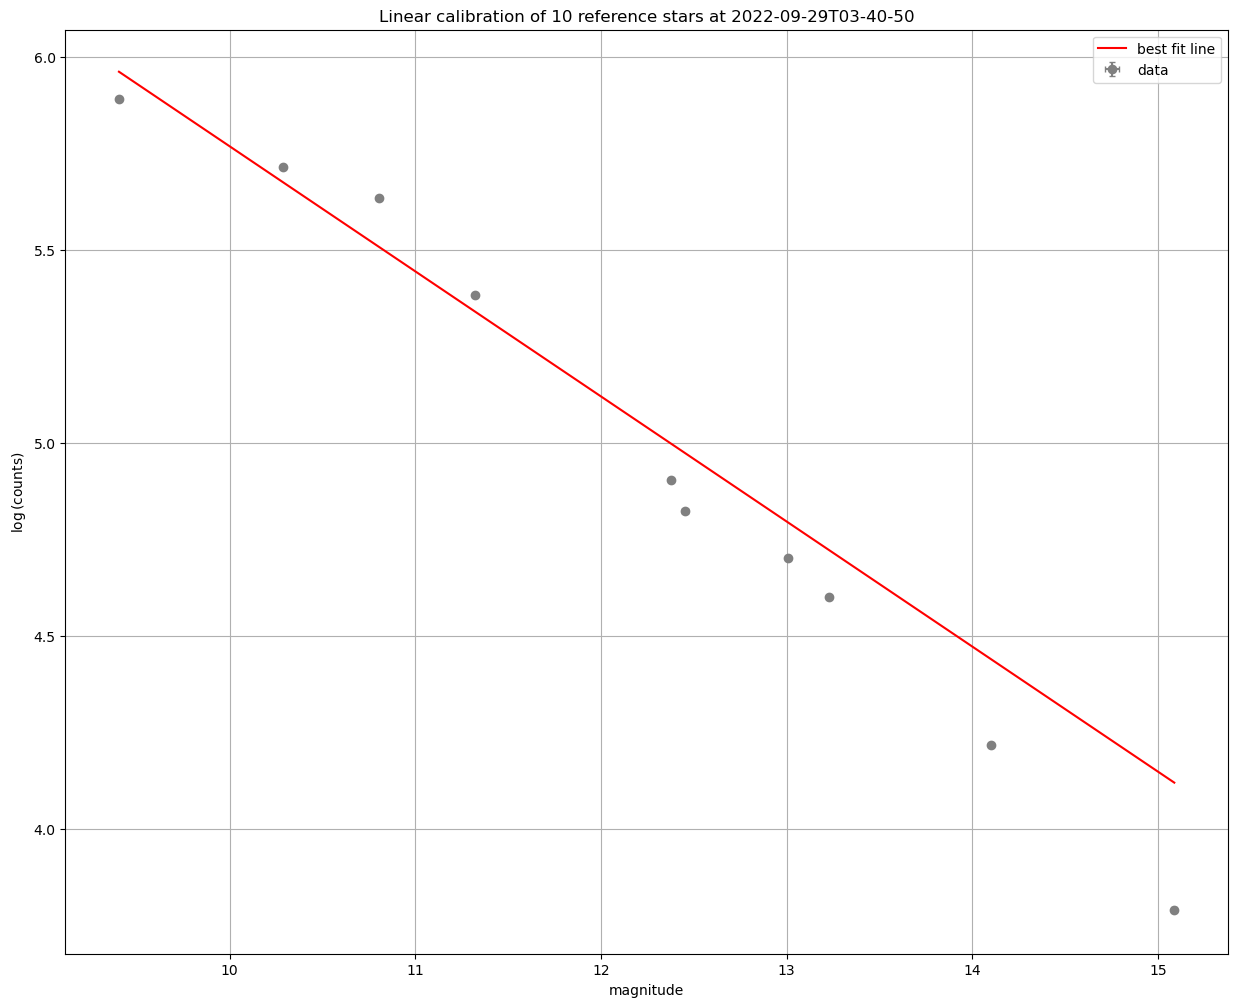

In [9]:
#using equation 3 for error in logf
err_logf = err_f_10/(flux_10*np.log(10))

#taking log of fluxes to retrieve log(counts) to plot
logf = np.log10(flux_10)

## adapted from 'FittingAFunctionToData(14.11.2022)', B. Waugh [6]

# degree of polynomial to fit, in this case 1 for a linear function y = m x + c
degree = 1

# Do the fit and unpack the results for the parameters and errors
# This time we have to give the weights as parameter w.
# The weights required by the polyfit function are (1/error)
params, cov = np.polyfit(mag_10,logf,degree,cov='unscaled', w=1/(err_logf))

# The values of the parameters of the best-fit line are returned as an array [m, c]
m, c = params

# take the square root of the diagonal of the covariant matrix to get the errors.
err_m, err_c = np.sqrt(np.diag(cov))

x_calib = np.linspace(min(mag_10),max(mag_10),1001)    # range of x values to plot
y_calib = m * x_calib + c                              # calculate corresponding y values

# Create a figure with the data and best-fit line
plt.title("Linear calibration of 10 reference stars at 2022-09-29T03-40-50")
plt.xlabel("magnitude")
plt.ylabel(r"$\log$(counts)")
plt.errorbar(mag_10,logf,xerr=err_m_10,yerr=err_logf,fmt='o',capsize=2,label='data', color='gray')
plt.plot(x_calib, y_calib, label='best fit line',color='r')
plt.legend()
plt.grid()

print(f"Slope = {m:.4f} +- {err_m:.4f}")
print(f"log(counts) axis intercept = {c:.3f} +- {err_c:.3f}")

<center> Fig. 3: Plot of linear calibration of 10 reference stars at 2022-09-29T03-40-50 </center>

## Task C: De-trending

### C1: Time selection

First in Task C, I used my previously defined image load function `img_load()` to retrieve the data and headers from the files. The observing times were then extracted from the headers into a string array. Using the <tt> datetime </tt> package I was then able to transform these times into a time array in units of hours, relative to the time of the first frame chosen, $t_0$.

In [10]:
#using frames 3,13,20,28. 3 was loaded earlier as data1, head1
#13
data2, head2 = img_load('./2022-09-29T04-06-08_Didymos_Red_T-25_60s_cal.fits')
#20
data3, head3 = img_load('./2022-09-29T04-23-10_Didymos_Red_T-25_60s_cal.fits')
#28
data4, head4 = img_load('./2022-09-29T04-36-49_Didymos_Red_T-25_60s_cal.fits')

#obs times as string array
obs_str = [head1['DATE-OBS'], head2['DATE-OBS'], head3['DATE-OBS'], head4['DATE-OBS']]

print(obs_str)

['2022-09-29T03:40:50.16', '2022-09-29T04:06:08.15', '2022-09-29T04:23:10.12', '2022-09-29T04:36:49.31']


In [11]:
# setting frame 3 to t0 (starting time)
t0 = dt.datetime.strptime(obs_str[0], '%Y-%m-%dT%H:%M:%S.%f')

# conversion factor for t1,2,3 into hours
dhr = dt.timedelta(hours=1)

# t1,2,3 are first converted to times from strings and then converted to
# a difference from t0 (frame 3)
t1 = (dt.datetime.strptime(obs_str[1], '%Y-%m-%dT%H:%M:%S.%f') - t0) / dhr
t2 = (dt.datetime.strptime(obs_str[2], '%Y-%m-%dT%H:%M:%S.%f') - t0) / dhr
t3 = (dt.datetime.strptime(obs_str[3], '%Y-%m-%dT%H:%M:%S.%f') - t0) / dhr

# forming time array, in units of hours
obs_t = np.array([0,t1,t2,t3])

print(obs_t)

[0.         0.42166389 0.70554444 0.93309722]


### C2: Information on image background noise

Now I created a function to automate calculating the background noise. This was done by slicing the data at the mode, which is the least susceptible average to many large flux values. Fitting a normal distribution to this subset of data resulted in estimates for the background noise and an error.

In [12]:
def back_lvl(data):
    """
    Estimates the background noise of an image,
    given the dataset. Returns this value and
    an uncertainty estimate
    """

    # the data must be flattened first so that a fit can be made
    data_flat = data.flatten()

    #using the mode to identify the cutoff point for noise side of histogram
    mode = stats.mode(data_flat)[0]
    
    #identifying the noise subset
    noise = data_flat[np.where(data_flat <= mode)]
    
    #fit parameters which can be used to estimate background level
    mean,std = stats.norm.fit(noise)
    
    return mean,std

#using above defined function
back1, err_back1 = back_lvl(data1)
back2, err_back2 = back_lvl(data2)
back3, err_back3 = back_lvl(data3)
back4, err_back4 = back_lvl(data4)

#shaping backgrounds & errors into arrays for loops later
backg = np.array([back1,back2,back3,back4])
err_backg = np.array([err_back1,err_back2,err_back3,err_back4])

print('Background noise levels for each frame:')
for i in range(4):   
    print(f'Frame {i+1}: {backg[i]:.0f} +- {err_backg[i]:.0f} ADUs')

Background noise levels for each frame:
Frame 1: 158 +- 19 ADUs
Frame 2: 154 +- 19 ADUs
Frame 3: 153 +- 19 ADUs
Frame 4: 148 +- 19 ADUs


### C3: Aperture photometry on reference stars

The next code cell is just a repeat of Task B2 on the other three frames for all 10 reference stars.  
The results are tabulated in the output.

In [13]:
# repeating B2 for each frame

#empty arrays to fill
flux_10_2 = np.zeros(10)
err_f_10_2 = np.zeros(10)

#looping ap() function for each star to calculate flux & error
for i in range(len(x_10)):
    flux = ap(data2, r, x_10[i], y_10[i])[2]
    flux_10_2[i] = flux_10_2[i] + flux
    
    err_f = ap(data2, r, x_10[i], y_10[i])[3]
    err_f_10_2[i] = err_f_10_2[i] + err_f

#empty arrays to fill
flux_10_3 = np.zeros(10)
err_f_10_3 = np.zeros(10)    

#looping ap() function for each star to calculate flux & error
for i in range(len(x_10)):
    flux = ap(data3, r, x_10[i], y_10[i])[2]
    flux_10_3[i] = flux_10_3[i] + flux
    
    err_f = ap(data3, r, x_10[i], y_10[i])[3]
    err_f_10_3[i] = err_f_10_3[i] + err_f

#empty arrays to fill
flux_10_4 = np.zeros(10)
err_f_10_4 = np.zeros(10)

#looping ap() function for each star to calculate flux & error
for i in range(len(x_10)):
    flux = ap(data4, r, x_10[i], y_10[i])[2]
    flux_10_4[i] = flux_10_4[i] + flux
    
    err_f = ap(data4, r, x_10[i], y_10[i])[3]
    err_f_10_4[i] = err_f_10_4[i] + err_f

    
# now each of the four frames have had aperture photometry completed,
# the arrays need to be reorganised so each star has its own,
# i.e. 10 1D arrays of length 4. For ease, this will be done
# as one 10D array which can be indexed for each star (a=0,b=1,...,j=9)
flux_40 = np.transpose(np.stack([flux_10, flux_10_2, flux_10_3, flux_10_4]))
err_f_40 = np.transpose(np.stack([err_f_10, err_f_10_2, err_f_10_3, err_f_10_4]))

print('Measured fluxes, by star')
print(tabulate(np.transpose(flux_40), tablefmt='pipe', headers=a2j))
print()
print('Errors in flux')
print(tabulate(np.transpose(err_f_40), tablefmt='pipe', headers=a2j))

Measured fluxes, by star
|     a |     b |       c |     d |      e |     f |      g |    h |      i |      j |
|------:|------:|--------:|------:|-------:|------:|-------:|-----:|-------:|-------:|
| 66761 | 39992 | 80381   | 16476 | 519160 | 50187 | 431159 | 6177 | 780470 | 242400 |
| 68963 | 38817 | 81047   | 16841 | 522294 | 52087 | 412806 | 7034 | 786424 | 245512 |
| 69295 | 38058 | 82872.5 | 18366 | 547961 | 53379 | 435266 | 6543 | 829074 | 251804 |
| 68264 | 39278 | 80117   | 17617 | 506076 | 50774 | 410554 | 6849 | 805029 | 247020 |

Errors in flux
|       a |       b |       c |       d |       e |       f |       g |       h |       i |       j |
|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| 258.385 | 199.984 | 283.519 | 128.365 | 720.529 | 224.027 | 656.628 | 78.6031 | 883.447 | 492.343 |
| 262.611 | 197.024 | 284.691 | 129.78  | 722.7   | 228.229 | 649.136 | 83.8766 | 886.81  | 495.493 |
| 263.243 | 195.089 | 287.88 

Next is creating the flux trend curves.  

I normalised each set of fluxes by dividing by the reference star's maximum flux, so each star has one value of 1, and three values just below (by varying amounts). I used a third-degree polynomial here, as the data obviously doesn't follow a straight line, and a quadratic did not capture the jump from the first to second to third data points accurately, since many of the stars do not follow the same dips in brightness. Most only increase slightly from frame 3 to 13, compared to the common brightest frame of 20 (for most of the stars, but not all), which is a more significant increase.  

With 10 flux trend curves, I took the mean of these to generate the mean flux trend curve, or an average of how the flux evolves over time.

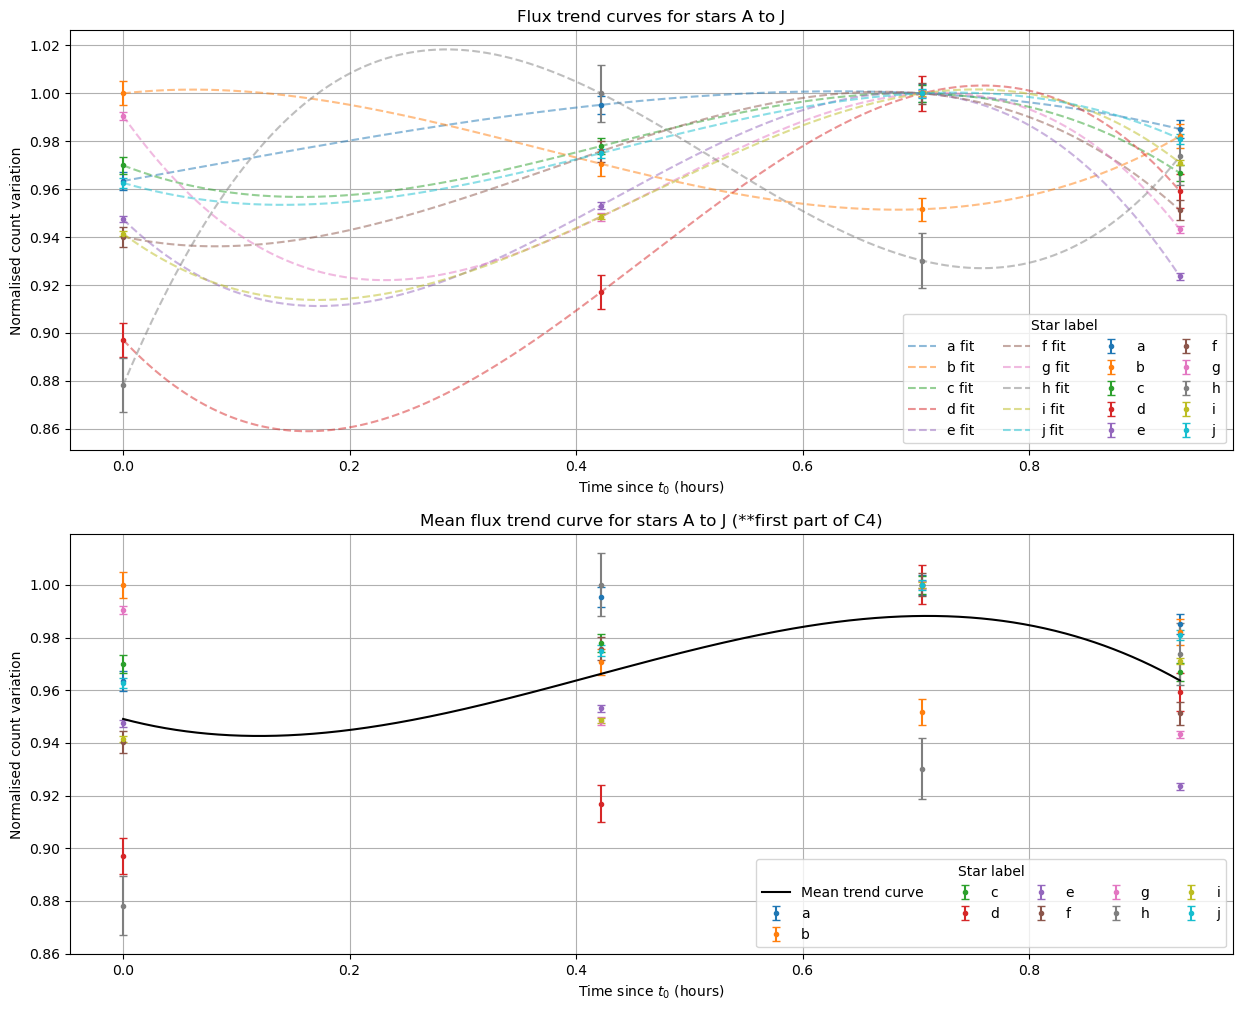

In [14]:
# for fitting polynomial to acquire curves
x_trend = np.linspace(0,np.max(obs_t),1001)
# degree of polynomial to fit - justification in markdown above
deg = 3

#configuring subplots
fig, ax = plt.subplots(2,1)

#empty arrays to input data
norm_f = np.zeros((10,4))
norm_err_f = np.zeros((10,4))
y_trend = np.zeros((10,1001))

#normalising count variation by dividing each star by its max value.
#the same is applied to the uncertainties.
for i in range(len(a2j)):
    norm_f[i] = flux_40[i]/np.max(flux_40[i])
    norm_err_f[i] = err_f_40[i]/np.max(flux_40[i])
    ax[0].errorbar(obs_t, norm_f[i],yerr=norm_err_f[i],fmt= '.',capsize=3, label=a2j[i], color=f'C{i}')
    ax[1].errorbar(obs_t, norm_f[i],yerr=norm_err_f[i],fmt= '.',capsize=3, label=a2j[i], color=f'C{i}')

#fitting a curve so each star has its own. these are then averaged and plotted separately    
    params_trend  = np.polyfit(obs_t,norm_f[i], deg, w=1/norm_err_f[i])
    y_trend[i] = np.poly1d(params_trend)(x_trend)
    ax[0].plot(x_trend, y_trend[i], '--', label=f'{a2j[i]} fit', color=f'C{i}', alpha=0.5)

# C4 - plotting the mean trend curve - the photometric time trend.
#this is done here for better visualisation & for comparison to all
#individual flux trend curves
y_trend_mean = np.mean(y_trend, axis=0)
ax[1].plot(x_trend,y_trend_mean, label='Mean trend curve', color='black')

###

# subplot of ALL trend curves
ax[0].grid()
ax[0].set_title('Flux trend curves for stars A to J')
ax[0].set_xlabel('Time since $t_0$ (hours)')
ax[0].set_ylabel('Normalised count variation')
ax[0].legend(loc='lower right', title='Star label', ncol=4)

# C4 - subplot of MEAN trend curve
ax[1].grid()
ax[1].set_title('Mean flux trend curve for stars A to J (**first part of C4)')
ax[1].set_xlabel('Time since $t_0$ (hours)')
ax[1].set_ylabel('Normalised count variation')
ax[1].legend(loc='lower right', title='Star label', ncol=5)

<center> Fig. 4: Subplots of flux trend curves for stars A to J (top), and the mean flux trend curve for stars A to J (bottom)</center>

### C4: De-trending photometric counts

As an uncertainty consideration, I took the offsets of each curve to the mean curve and plotted these. The most positive and negative offsets will be considered after plotting.

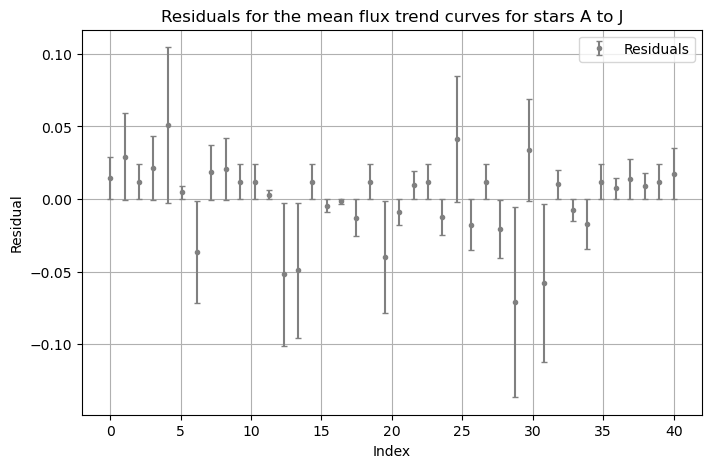

In [15]:
#finding residuals - first the time values in the polynomial fit
#that correspond to obs_t (the frame times)
resid_loc = (obs_t/np.max(obs_t) * 1000).astype(int)
y_mean_frames = y_trend_mean[resid_loc]
# difference between the actual norm flux values and the fit to find residual
residuals = norm_f - y_mean_frames

# error bars
err_resid = abs(residuals) * norm_f / y_mean_frames

# plotting - the residuals (& errors) have been flattened for ease of plotting
plt.figure(figsize=(8,5))
plt.errorbar(np.linspace(0,40,40),residuals.flatten(), yerr=err_resid.flatten(), fmt='.', label='Residuals', capsize=2, color='gray')
plt.grid()
plt.title('Residuals for the mean flux trend curves for stars A to J')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.legend(loc='upper right', ncol=5)

<center> Fig. 5: Plot of residuals for the mean flux trend curves for stars A to J </center>  


From the above plotting of the flattened residuals (flattened purely for visualisation), the data indexed 4 and 28 are the upper and lower bounds respectively. I think these are reasonable estimates for uncertainties in the mean trend curve due to two stars not having frame 20 as their brightest, as the 'brightest frame' may not be constant across the whole image. These two bounds are printed below.

In [16]:
# upper bound - taken as the most positive residual visually
mean_hi_lim = residuals.flatten()[4] + err_resid.flatten()[4]

#lower bound - taken as the most negative residual visually
mean_lo_lim = residuals.flatten()[28] - err_resid.flatten()[28]

print(f"Upper limit of mean trend curve: +{mean_hi_lim:.3f}")
print(f"Lower limit of mean trend curve: {mean_lo_lim:.3f}")

Upper limit of mean trend curve: +0.105
Lower limit of mean trend curve: -0.137


Having now obtained the mean flux trend curve and some uncertainty considerations, I detrended all the reference star fluxes. This was done by removing the background counts acquired in C2 and correcting for gains by using the 'photometric time trend' (i.e. the mean flux curve) in C4.  

The errors were propagated using the standard propagation for some function $ Z(A,B) = \frac{A}{B} $:

$$ \tag{4} \left( \frac{\Delta Z}{Z} \right)^2 = \left( \frac{\Delta A}{A} \right)^2 + \left( \frac{\Delta B}{B} \right)^2 $$  

from the Data Analysis and Statistics Booklet <a href="https://moodle.ucl.ac.uk/course/view.php?id=39271">[7]</a>.

In [17]:
# detrending the initial fluxes by removing the background noise and correcting for gains
flux_40_detr = (flux_40 - backg) / y_mean_frames

# error propagation: eqn 4                       dA                       A                dB               B
err_f_40_detr = flux_40_detr*np.sqrt(((err_f_40**2 + err_backg**2)/(flux_40-backg)**2 + residuals**2/y_mean_frames**2))


print('Detrended and background corrected fluxes, by star')
print(tabulate(np.transpose(flux_40_detr), tablefmt='pipe', headers=a2j))
print()
print('Errors in flux')
print(tabulate(np.transpose(err_f_40_detr), tablefmt='pipe', headers=a2j))

Detrended and background corrected fluxes, by star
|       a |       b |       c |       d |      e |       f |      g |       h |      i |      j |
|--------:|--------:|--------:|--------:|-------:|--------:|-------:|--------:|-------:|-------:|
| 70176   | 41971   | 84526.7 | 17193.4 | 546844 | 52712.9 | 454122 | 6341.95 | 822172 | 255237 |
| 71226   | 40021.3 | 83734.4 | 17273.5 | 540478 | 53757.3 | 427145 | 7122.08 | 813884 | 253975 |
| 69968.8 | 38358.3 | 83708.7 | 18430.8 | 554359 | 53862.5 | 440316 | 6466.4  | 838833 | 254660 |
| 70682.8 | 40604.8 | 82982.4 | 18127.7 | 524990 | 52533.9 | 425869 | 6953.98 | 835206 | 256174 |

Errors in flux
|        a |        b |        c |       d |        e |       f |        g |       h |        i |       j |
|---------:|---------:|---------:|--------:|---------:|--------:|---------:|--------:|---------:|--------:|
| 1095.31  | 2261.49  | 1880.91  | 951.774 |  1215.02 | 547.374 | 19858.9  | 481.519 |  6743.75 | 3685.52 |
| 2165.4   |  278.312

Now, the fluxes across all four frames for all 10 reference stars have been detrended, and are much closer in value. Of note is star h, which still has a wide range of fluxes. This may be due to star h being the dimmest of all the chosen stars so larger percentage variations in flux are expected. However these more extreme fluxes are accounted for by the larger uncertainties due to propagating the offsets from the photometric time trend.

## Task D: D for Didymos

Now for Didymos!!

### D1: Didymos astrometry

First of all, I need to locate Didymos. I plotted all four chosen frames as subplots and compared by eye to find Didymos in each frame, knowing that it will be close to the centre in the first frame. I have circled Didymos in each frame, and previous frames' circles are made semitransparent to show the progress of Didymos across the sky.

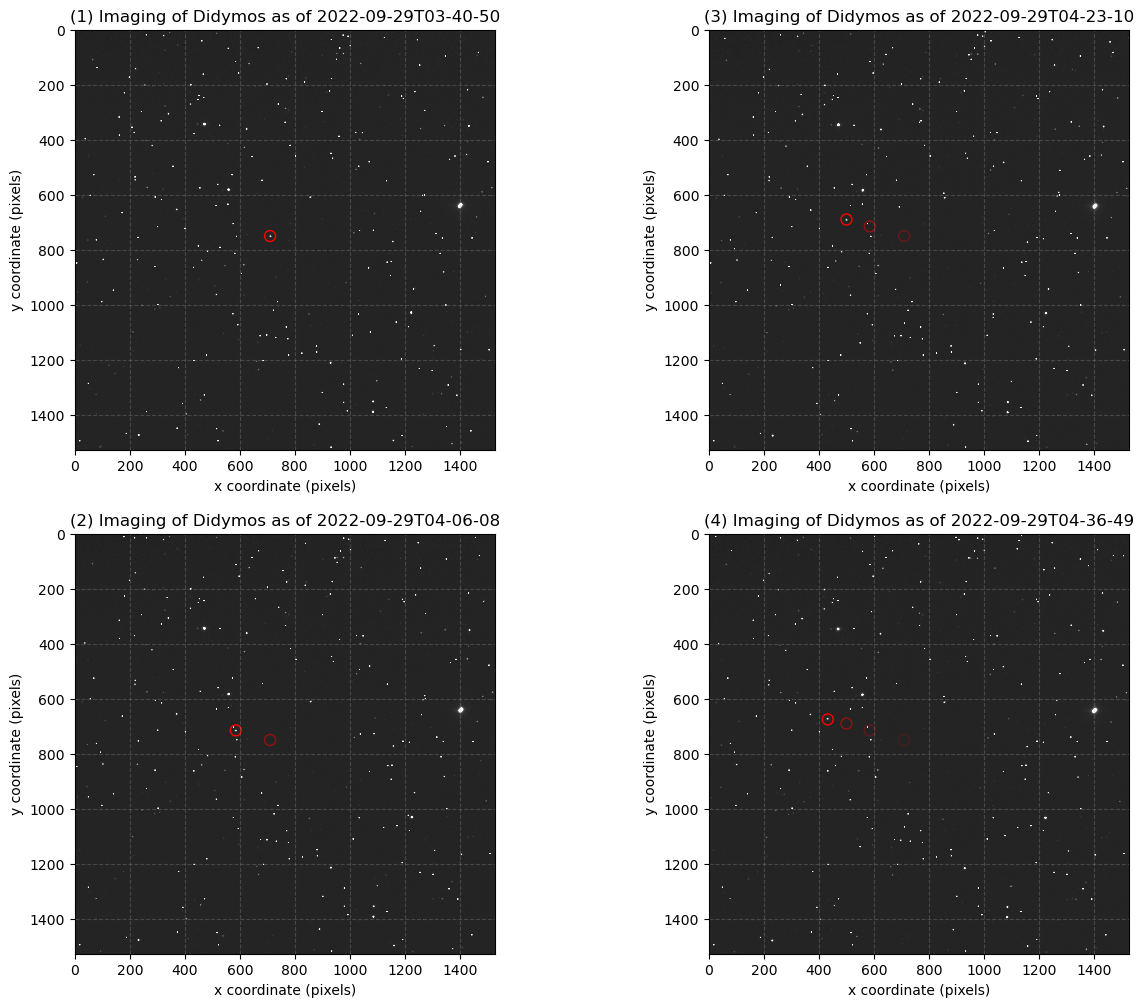

In [18]:
#first, find approximate coordinates of didymos in each frame to base the subset around

#configuring subplots
fig, ax = plt.subplots(2,2)

for i in range(2):
    for j in range(2):        
        ax[i,j].grid(linestyle='--', alpha=0.25)
        ax[i,j].set_xlabel('x coordinate (pixels)')
        ax[i,j].set_ylabel('y coordinate (pixels)')

        
# upper left
ax[0,0].set_title('(1) Imaging of Didymos as of 2022-09-29T03-40-50')
quicksubplot(data1, 0.5,3,0,0)

#circling didymos
x1_guess, y1_guess = [710,750]
ax[0,0].add_patch(plt.Circle((x1_guess, y1_guess),20, color='r', fill=False))


#lower left
ax[1,0].set_title('(2) Imaging of Didymos as of 2022-09-29T04-06-08')
quicksubplot(data2, 0.5,3,1,0)

#circling didymos. previous location faintly circled
x2_guess,y2_guess = [585,715]
ax[1,0].add_patch(plt.Circle((x2_guess,y2_guess),20, color='r', fill=False))
ax[1,0].add_patch(plt.Circle((x1_guess,y1_guess),20, color='r', fill=False, alpha=0.5))


#upper right
ax[0,1].set_title('(3) Imaging of Didymos as of 2022-09-29T04-23-10')
quicksubplot(data3, 0.5,3,0,1)

#circling didymos. previous locations faintly circled
x3_guess,y3_guess = [500,690]
ax[0,1].add_patch(plt.Circle((x3_guess,y3_guess),20, color='r', fill=False))
ax[0,1].add_patch(plt.Circle((x2_guess,y2_guess),20, color='r', fill=False, alpha=0.5))
ax[0,1].add_patch(plt.Circle((x1_guess,y1_guess),20, color='r', fill=False, alpha=0.3))


#lower right
ax[1,1].set_title('(4) Imaging of Didymos as of 2022-09-29T04-36-49')
quicksubplot(data4, 0.5,3,1,1)

#circling didymos. previous locations faintly circled
x4_guess,y4_guess = [432,675]
ax[1,1].add_patch(plt.Circle((x4_guess,y4_guess),20, color='r', fill=False))
ax[1,1].add_patch(plt.Circle((x3_guess,y3_guess),20, color='r', fill=False, alpha=0.5))
ax[1,1].add_patch(plt.Circle((x2_guess,y2_guess),20, color='r', fill=False, alpha=0.25))
ax[1,1].add_patch(plt.Circle((x1_guess,y1_guess),20, color='r', fill=False, alpha=0.15))

<center> Fig. 6: Imaging of Didymos at four different times, with Didymos circled </center>  


By now, the position (and direction of motion) of Didymos is clear. In order to pinpoint its position in each frame, I need to consider the PSFs. By considering a small subset around each first guess of coordinates I create a surface plot of the counts of Didymos, and use the maximum of these subplots to retrieve exact pixel coordinates of Didymos, and then convert to RA/Dec.

<function matplotlib.pyplot.show(close=None, block=None)>

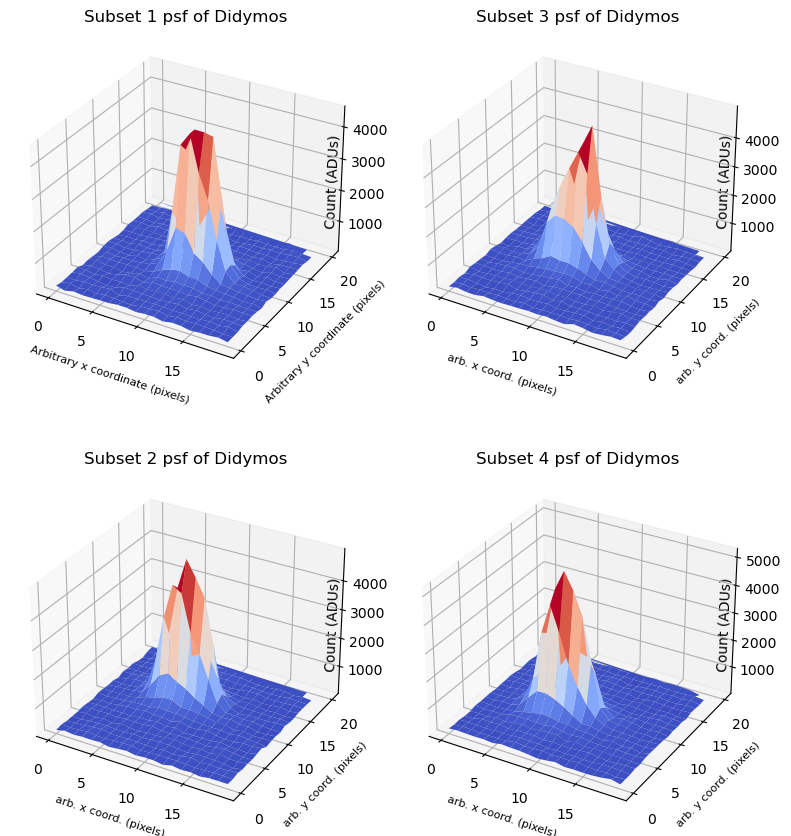

In [19]:
### surface plots from task 4 ###

def make_2d(subset):
    """
    Returns x coordinates and y coordinates as 2x 2D arrays,
    given the subset as input.
    """
    sz = np.shape(subset)[0]

    tmp   = np.linspace(0,sz,sz*sz)
    tmp2  = np.reshape(tmp,(sz,sz))
    yy    = np.floor(tmp2)     # floor truncates the array (as pixel values are integers)
    tmp3  = sz*(tmp2-yy)
    xx    = np.floor(tmp3)
    
    return xx,yy

#defining subsets - 20x20 around Didymos
subset1 = data1[y1_guess-10:y1_guess+10,x1_guess-10:x1_guess+10]
subset2 = data2[y2_guess-10:y2_guess+10,x2_guess-10:x2_guess+10]
subset3 = data3[y3_guess-10:y3_guess+10,x3_guess-10:x3_guess+10]
subset4 = data4[y4_guess-10:y4_guess+10,x4_guess-10:x4_guess+10]

# surface subplots
fig = plt.figure(figsize=(8,10),layout='tight')

ax = fig.add_subplot(2,2,1, projection='3d')
ax = fig.gca()
surf = ax.plot_surface(make_2d(subset1)[0], make_2d(subset1)[1], subset1, cmap=cm.coolwarm)
ax.set_title('Subset 1 psf of Didymos')
ax.set_xlabel('Arbitrary x coordinate (pixels)',fontsize=8)
ax.set_ylabel('Arbitrary y coordinate (pixels)',fontsize=8)
ax.set_zlabel('Count (ADUs)',labelpad=-25)

ax = fig.add_subplot(2,2,3, projection='3d')
ax = fig.gca()
surf = ax.plot_surface(make_2d(subset2)[0], make_2d(subset2)[1], subset2, cmap=cm.coolwarm)
ax.set_title('Subset 2 psf of Didymos')
ax.set_xlabel('arb. x coord. (pixels)',fontsize=8)
ax.set_ylabel('arb. y coord. (pixels)',fontsize=8)
ax.set_zlabel('Count (ADUs)',labelpad=-25)

ax = fig.add_subplot(2,2,2, projection='3d')
ax = fig.gca()
surf = ax.plot_surface(make_2d(subset3)[0], make_2d(subset3)[1], subset3, cmap=cm.coolwarm)
ax.set_title('Subset 3 psf of Didymos')
ax.set_xlabel('arb. x coord. (pixels)',fontsize=8)
ax.set_ylabel('arb. y coord. (pixels)',fontsize=8)
ax.set_zlabel('Count (ADUs)',labelpad=-25)

ax = fig.add_subplot(2,2,4, projection='3d')
ax = fig.gca()
surf = ax.plot_surface(make_2d(subset4)[0], make_2d(subset4)[1], subset4, cmap=cm.coolwarm)
ax.set_title('Subset 4 psf of Didymos')
ax.set_xlabel('arb. x coord. (pixels)',fontsize=8)
ax.set_ylabel('arb. y coord. (pixels)',fontsize=8)
ax.set_zlabel('Count (ADUs)',labelpad=-25)

plt.show

<center> Fig. 7: Subplots of subset PSFs of Didymos </center>

In [20]:
### adapted from task 4 provided cell ###

# function to use to tidy up the cell
def didy_locator(subset,data,head):
    """
    Finds the x,y coordinates (in pixels) of
    Didymos, given the subset data and full image data.
    Returns the max counts, the x,y coords. (pixels), and the ra,dec.
    """
    _max = np.max(subset)
    wmaxall = np.where(data.flatten() == _max)
    x = make_2d(data)[0].flatten()[wmaxall].item()
    y = make_2d(data)[1].flatten()[wmaxall].item()
    ra,dec = pix2cel(x,y,head)
    
    return _max,x,y,ra,dec

# perform above function on each frame to retrieve Didymos coords in pixels & RA/Dec
max1,x_d1,y_d1,ra_d1,dec_d1 = didy_locator(subset1,data1,head1)
max2,x_d2,y_d2,ra_d2,dec_d2 = didy_locator(subset2,data2,head2)
max3,x_d3,y_d3,ra_d3,dec_d3 = didy_locator(subset3,data3,head3)
max4,x_d4,y_d4,ra_d4,dec_d4 = didy_locator(subset4,data4,head4)

# forming above into arrays
ra_didy = np.array([ra_d1,ra_d2,ra_d3,ra_d4])
dec_didy = np.array([dec_d1,dec_d2,dec_d3,dec_d4])
x_pix_didy = np.array([x_d1,x_d2,x_d3,x_d4])
y_pix_didy = np.array([y_d1,y_d2,y_d3,y_d4])
max_didy = np.array([max1,max2,max3,max4])

for i in range(4):
    print(f'Max value of image {i+1} (ADUs): {max_didy[i]}')
    print(f'Coordinates of Didymos (pixels): ({x_pix_didy[i]},{y_pix_didy[i]})')
    print(f'Coordinates of Didymos (RA,Dec): {ra_didy[i]},{dec_didy[i]}')
    print()

Max value of image 1 (ADUs): 4550
Coordinates of Didymos (pixels): (710.0,750.0)
Coordinates of Didymos (RA,Dec): 57.413230077786125,-31.8141663813123

Max value of image 2 (ADUs): 4993
Coordinates of Didymos (pixels): (583.0,717.0)
Coordinates of Didymos (RA,Dec): 57.45648982230525,-31.80151420444744

Max value of image 3 (ADUs): 4977
Coordinates of Didymos (pixels): (500.0,691.0)
Coordinates of Didymos (RA,Dec): 57.485217428136494,-31.79304552925976

Max value of image 4 (ADUs): 5203
Coordinates of Didymos (pixels): (430.0,674.0)
Coordinates of Didymos (RA,Dec): 57.50886143249314,-31.78596839957799



Having obtained RA and Dec for Didymos in each frame, these are plotted as a function of time and have each had a linear fit applied. These straight line fits are important to estimate Didymos's angular velocity.

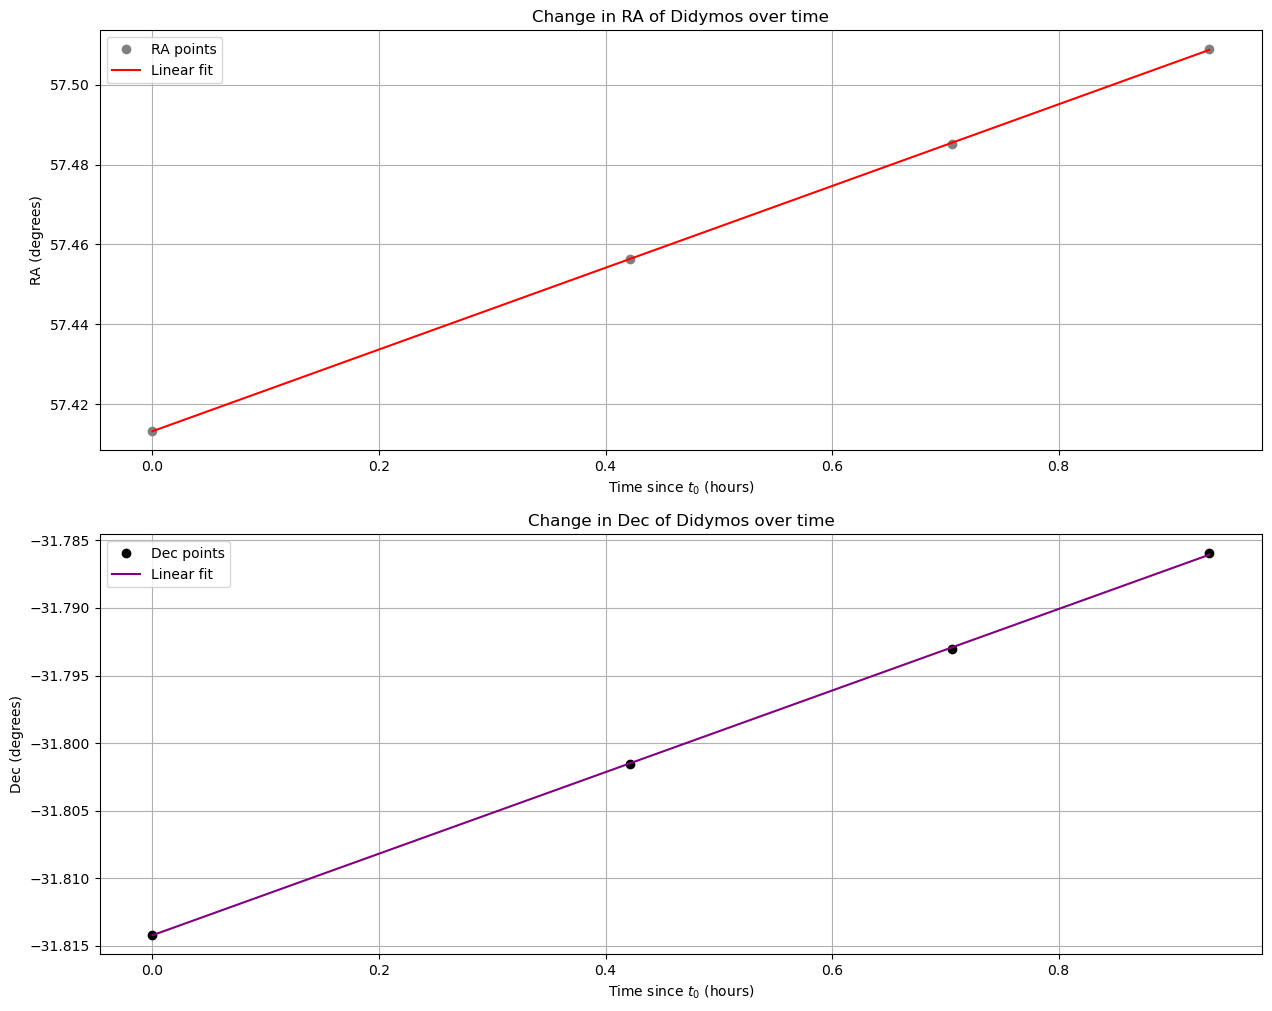

In [21]:
#configuring subplots
fig, ax = plt.subplots(2,1)

# straight line fit for ra
params_ra, cov_ra = np.polyfit(obs_t,ra_didy,degree,cov='unscaled')
m_ra, c_ra = params_ra
err_m_ra, err_c_ra = np.sqrt(np.diag(cov_ra))
y_calib_ra = m_ra * x_trend + c_ra

# straight line fit for dec
params_dec, cov_dec = np.polyfit(obs_t,dec_didy,degree,cov='unscaled')
m_dec, c_dec = params_dec
err_m_dec, err_c_dec = np.sqrt(np.diag(cov_dec))
y_calib_dec = m_dec * x_trend + c_dec


# subplot of RA
ax[0].grid()
ax[0].plot(obs_t,ra_didy,'o', color='gray', label='RA points')
ax[0].plot(x_trend,y_calib_ra, color='red', label='Linear fit')
ax[0].set_title('Change in RA of Didymos over time')
ax[0].set_xlabel('Time since $t_0$ (hours)')
ax[0].set_ylabel('RA (degrees)')
ax[0].legend()

# C4 - subplot of Dec
ax[1].grid()
ax[1].plot(obs_t,dec_didy,'o', color='black', label='Dec points')
ax[1].plot(x_trend,y_calib_dec, color='purple', label='Linear fit')
ax[1].set_title('Change in Dec of Didymos over time')
ax[1].set_xlabel('Time since $t_0$ (hours)')
ax[1].set_ylabel('Dec (degrees)')
ax[1].legend()

<center> Fig. 8: Subplots of the change in RA (top) and Dec (bottom) of Didymos over time </center>  


To calculate the angular velocity (or proper motion) of the Didymos system, we need to first consider RA and Dec separately. These were computed above as `m_ra` and `m_dec`, and correspond to the proper motions in right ascension, $\mu_{\alpha}$, and declination, $\mu_{\delta}$, respectively. These are then combined using

$$ \tag{5} \mu^2 = \mu_{\delta}^2 + \mu_{\alpha}^2 \cdot \cos^2\delta $$

where $\delta$ is the average  declination. The RA factor must be multiplied by $\cos^2\delta$ to account for the widening in RA from the poles towards the equator <a href="https://en.wikipedia.org/wiki/Proper_motion">[8]</a>.

Then, to propagate errors, we take the partial derivatives of $\mu$ with respect to $\mu_{\delta}$ and $\mu_{\alpha}$:

$$ \tag{6.1} \frac{\partial \mu}{\partial \mu_{\delta}} = \frac{\mu_{\delta}}{\sqrt {\mu_{\alpha}^2 \cdot \cos^2\delta + \mu_{\alpha}^2}} $$

$$ \tag{6.2} \frac{\partial \mu}{\partial \mu_{\alpha}} = \frac{\mu_{\alpha} \cdot \cos^2\delta}{\sqrt {\mu_{\alpha}^2 \cdot \cos^2\delta + \mu_{\alpha}^2}} $$

and add these in quadrature to obtain the uncertainty in $\mu$, $\Delta \mu$, as

$$ \tag{7.1} \Delta \mu = \sqrt {\frac{\partial \mu}{\partial \mu_{\delta}}^2 (\Delta \mu_{\delta})^2 + \frac{\partial \mu}{\partial \mu_{\alpha}}^2 (\Delta \mu_{\alpha})^2} $$

(Data Analysis and Statistics Booklet, eqn 6 <a href="https://moodle.ucl.ac.uk/course/view.php?id=39271">[7]</a>) yielding

$$ \tag{7.2} \Delta \mu = \sqrt {\frac{\mu_{\delta}}{\sqrt {\mu_{\alpha}^2 \cdot \cos^2\delta + \mu_{\delta}^2}}^2 (\Delta \mu_{\delta})^2 + \frac{\mu_{\alpha} \cdot \cos^2\delta}{\sqrt {\mu_{\alpha}^2 \cdot \cos^2\delta + \mu_{\delta}^2}}^2 (\Delta \mu_{\alpha})^2} $$

In [22]:
# calculating delta in eqn 5 (IN RADIANS for np.cos)
delta = np.mean(dec_didy) * 180/np.pi

#using eqn 5
ang_v = np.sqrt(m_dec**2 + m_ra**2 * np.cos(delta)**2)

#using the fit errors from the covariant matrix and propagating using eqn 7.2
err_ang_v = np.sqrt((m_dec**2 * err_m_dec**2 + m_ra**2 * err_m_ra**2 * np.cos(delta)**4)/(m_dec**2 + m_ra**2 * np.cos(delta)**2))

print(f"The angular velocity of Didymos is {ang_v:.3f} +- {err_ang_v:.3f} degrees/hour")

The angular velocity of Didymos is 0.105 +- 1.411 degrees/hour


The error on the calculated angular velocity is around 1400% - which is extremely large. Nevertheless, this value now needs to be compared to data from the JPL Ephemeris service <a href="https://ssd.jpl.nasa.gov/horizons/app.html#/">[2]</a>.  

Using this site, I obtained RA and Dec positions for Didymos at 0300, 0400 and 0500 UTC the same day the frames were taken, as well as an actual value for the angular velocity, in different units. The RA was also in hms so this needed to be converted too.  

These recovered positions are plotted against my positions from the frames.

The actual angular velocity is 0.1074787 degrees/hour


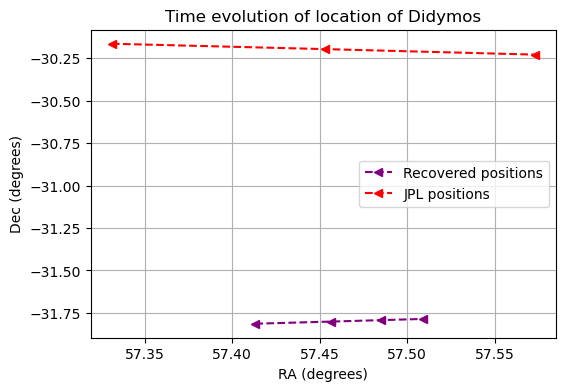

In [23]:
def hms2deg(h,m,s):
    """
    Converts the hms format in JPL to decimal degrees
    """
    d = 15*h + 15*m/60 + 15*s/3600
    return d

# data from JPL Ephemeris service [2]
jpl_ra_hms = np.array([[3,49,19.51],[3,49,48.74],[3,50,17.48]])
jpl_dec_raw = np.array([[-31,50,9.8],[-31,48,15.5],[-31,46,18.8]])
jpl_v_raw = 6.4487217    # in arcsecs/min

#to convert arcsecs/min to deg/hr, /3600 then *60 => net /60
jpl_v = jpl_v_raw/60

print(f"The actual angular velocity is {jpl_v:.7f} degrees/hour")

#to convert to decimal degrees, jpl_ra_hms can pass through the hms2deg() function defined above.
#however, for the decs, it's simply the same function but /15
# (which is just equivalent to converting to decimal degrees)
jpl_ra = np.zeros(3)
jpl_dec = np.zeros(3)
for i in range(3):
    jpl_ra[i] = hms2deg(jpl_ra_hms[i,0],jpl_ra_hms[i,1],jpl_ra_hms[i,2])
    jpl_dec[i] = hms2deg(jpl_dec_raw[i,0],jpl_dec_raw[i,1],jpl_dec_raw[i,2])/15

#plotting
plt.figure(figsize=(6,4))
plt.plot(ra_didy,dec_didy, '<--', label='Recovered positions', color='purple')
plt.plot(jpl_ra,jpl_dec, '<--', label='JPL positions', color='r')
plt.grid()
plt.title('Time evolution of location of Didymos')
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.legend(loc='best')

<center> Fig. 9: Plot of time evolution of the location of Didymos </center>  


Comparing the actual angular velocity to my calculated value, the actual value was 0.107 $^{\circ}$/hr which lies within my calculation of 0.105 $\pm$ 1.411 $^{\circ}$/hr. Even discounting the abnormally large uncertainty, the actual value lies within ~2% of the calculated value, suggesting an accurate calculation in the absolute value.  

From the plot of RA and Dec, it is clear that there is an offset in Dec. The RA values seem to match. This slight Dec offset may be caused by the frames being assumed to have already been rotated; if they are at a slight angle this could cause slight offsets in RA and Dec.

### D2: Didymos photometry

For the photometry of Didymos, I simply used my `ap()` function on each frame at the peak PSF coordinates. To ensure this all went smoothly I then plotted small subsets around Didymos in each frame and their respective apertures and annuli.

In [24]:
#using aperture photometry function on each frame.
# unfortunately a loop isn't particularly
# straightforward here as the function uses
# the data as an input
flux_d1 = ap(data1, r, x_d1, y_d1)[2]
err_f_d1 = ap(data1, r, x_d1, y_d1)[3]

flux_d2 = ap(data2, r, x_d2, y_d2)[2]
err_f_d2 = ap(data2, r, x_d2, y_d2)[3]

flux_d3 = ap(data3, r, x_d3, y_d3)[2]
err_f_d3 = ap(data3, r, x_d3, y_d3)[3]

flux_d4 = ap(data4, r, x_d4, y_d4)[2]
err_f_d4 = ap(data4, r, x_d4, y_d4)[3]

flux_d = np.array([flux_d1,flux_d2,flux_d3,flux_d4])
err_f_d = np.array([err_f_d1,err_f_d2,err_f_d3,err_f_d4])

print('Raw fluxes of Didymos in each frame:')
for i in range(4):
    print(f'{i+1}: {flux_d[i]:.0f} +- {err_f_d[i]:.0f} ADUs')

Raw fluxes of Didymos in each frame:
1: 63249 +- 251 ADUs
2: 64160 +- 270 ADUs
3: 64280 +- 254 ADUs
4: 66284 +- 257 ADUs


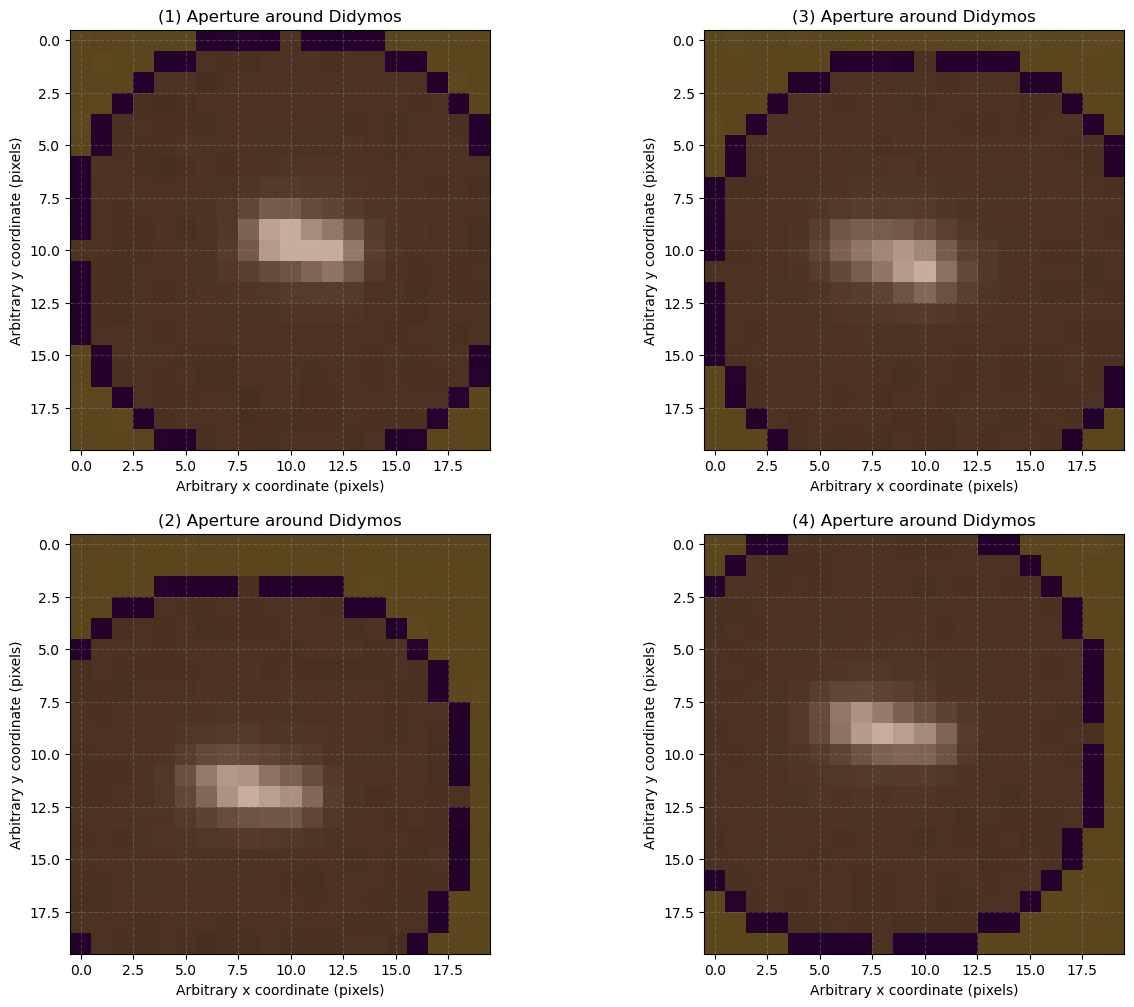

In [25]:
#just a check to make sure the apertures look appropriate for above flux calculations.
#plotting subplots, 1 for each frame
fig, ax = plt.subplots(2,2)

for i in range(2):
    for j in range(2):        
        ax[i,j].grid(linestyle='--', alpha=0.25)
        ax[i,j].set_xlabel('Arbitrary x coordinate (pixels)')
        ax[i,j].set_ylabel('Arbitrary y coordinate (pixels)')

ax[0,0].set_title('(1) Aperture around Didymos')
ax[0,0].imshow(subset1, cmap='gray')
ax[0,0].imshow(ap(data1, r, x_d1, y_d1)[0][y1_guess-10:y1_guess+10,x1_guess-10:x1_guess+10], alpha=0.3)
ax[0,0].imshow(ap(data1, r, x_d1, y_d1)[1][y1_guess-10:y1_guess+10,x1_guess-10:x1_guess+10], alpha=0.3)

ax[1,0].set_title('(2) Aperture around Didymos')
ax[1,0].imshow(subset2, cmap='gray')
ax[1,0].imshow(ap(data2, r, x_d2, y_d2)[0][y2_guess-10:y2_guess+10,x2_guess-10:x2_guess+10], alpha=0.3)
ax[1,0].imshow(ap(data2, r, x_d2, y_d2)[1][y2_guess-10:y2_guess+10,x2_guess-10:x2_guess+10], alpha=0.3)

ax[0,1].set_title('(3) Aperture around Didymos')
ax[0,1].imshow(subset3, cmap='gray')
ax[0,1].imshow(ap(data3, r, x_d3, y_d3)[0][y3_guess-10:y3_guess+10,x3_guess-10:x3_guess+10], alpha=0.3)
ax[0,1].imshow(ap(data3, r, x_d3, y_d3)[1][y3_guess-10:y3_guess+10,x3_guess-10:x3_guess+10], alpha=0.3)

ax[1,1].set_title('(4) Aperture around Didymos')
ax[1,1].imshow(subset4, cmap='gray')
ax[1,1].imshow(ap(data4, r, x_d4, y_d4)[0][y4_guess-10:y4_guess+10,x4_guess-10:x4_guess+10], alpha=0.3)
ax[1,1].imshow(ap(data4, r, x_d4, y_d4)[1][y4_guess-10:y4_guess+10,x4_guess-10:x4_guess+10], alpha=0.3)

<center> Fig. 10: Subplots of apertures and annuli used for photometry around Didymos </center>


Now I'm happy with the aperture photometry, these calculated fluxes need to be detrended. Like in C4, I take away the background noise and divide by the photometric time trend, and propagate uncertainties following equation 4.

In [26]:
# finding residuals from mean trend curve and normed Didymos fluxes
resid_didy = flux_d/np.max(flux_d) - y_mean_frames

# detrending the initial fluxes by removing the background noise and correcting for gains
flux_d_detr = (flux_d - backg) / y_mean_frames

# error propagation: eqn 4
err_f_d_detr = flux_d_detr*np.sqrt(((err_f_d**2 + err_backg**2)/(flux_d-backg)**2 + resid_didy**2/y_mean_frames**2))

print('Detrended fluxes of Didymos in each frame:')
for i in range(4):
    print(f'{i+1}: {flux_d_detr[i]:.0f} +- {err_f_d_detr[i]:.0f} ADUs')

Detrended fluxes of Didymos in each frame:
1: 66476 +- 446 ADUs
2: 66254 +- 308 ADUs
3: 64894 +- 1236 ADUs
4: 68629 +- 2599 ADUs


Using the four fluxes above, I fit a straight line to the data. I then take the mean of this straight line fit and use as an estimate for the actual flux of Didymos, as we are assuming that the photometry of Didymos is constant over this brief period. This estimate is plotted as a horizontal line, along with the fluxes printed above. Bounds for this flux estimate are plotted, by using the error obtained from the straight line fit and adding/subtracting for the upper/lower limits.

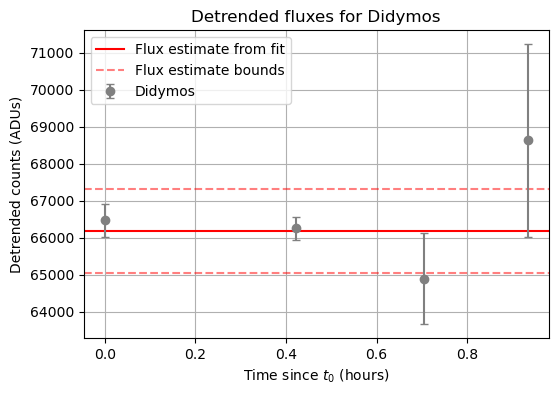

In [27]:
# straight line fit as done a few times already
params_f_didy, cov_f_didy = np.polyfit(obs_t,flux_d_detr,degree,cov='unscaled', w=1/err_f_d_detr)
m_f_didy, c_f_didy = params_f_didy
err_m_f_didy, err_c_f_didy = np.sqrt(np.diag(cov_f_didy))
y_f_didy = m_f_didy * x_trend + c_f_didy  # calculate corresponding y values

#taking the average of the fit line, as it is a strong assumption that
#the photometry was constant over this brief time interval.
#this leaves a horizontal line, where upper & lower limits can be
#applied using the error from the fit
flux_d_avg = np.mean(y_f_didy)

#plotting everything incl estimate (& bounds)
plt.figure(figsize=(6,4))
plt.grid()
plt.title('Detrended fluxes for Didymos')
plt.xlabel('Time since $t_0$ (hours)')
plt.ylabel('Detrended counts (ADUs)')
plt.axhline(flux_d_avg,color='r', label='Flux estimate from fit')
plt.axhline(flux_d_avg+err_m_f_didy,color='r', linestyle='--', label='Flux estimate bounds', alpha=0.5)
plt.axhline(flux_d_avg-err_m_f_didy,color='r', linestyle='--', alpha=0.5)
plt.errorbar(obs_t, flux_d_detr, yerr=err_f_d_detr, fmt='o',capsize=3, label = 'Didymos',color='gray')
plt.legend(loc='best')

<center> Fig. 11: Plot of the detrended fluxes for Didymos </center>

In [28]:
print(f'The average detrended flux from the fit is {flux_d_avg:.0f} +- {err_m_f_didy:.0f} ADUs')

The average detrended flux from the fit is 66192 +- 1137 ADUs


From the plot, the flux for Didymos is 66200 $\pm$ 1100 ADUs. What is noticeable about the plot is that there is a dip in brightness approximately 0.7 hours after the first frame. However, this dimming is short-lived, suggesting it is not caused by the transit of Dimorphos, and might be due to the photometric time trend not being suitable to use on the fluxes of Didymos, or there is some other very fast transiting object in orbit of Didymos, obscuring some of it.  

Next is comparing the uncertainty from the photometry of Didymos to the spread in detrended fluxes.

In [29]:
spread_f_didy = np.max(flux_d_detr) - np.min(flux_d_detr)
unc_f_didy = np.mean(err_f_d)
print(f'Uncertainty from initial photometry ~ +- {unc_f_didy:.0f} ADUs (averaged)')
print()
print(f'Spread in detrended values = +- {spread_f_didy:.0f} ADUs')

Uncertainty from initial photometry ~ +- 258 ADUs (averaged)

Spread in detrended values = +- 3734 ADUs


The spread in detrended values is much greater than the uncertainties from the initial photometry. This comparatively large spread is weighted by the third frame used (frame 20), in which Didymos appears dimmer. This is expected, as the individual photometry uncertainties only account for one frame each. However I believe the spread may be a more accurate estimate for the uncertainty than the uncertainty from the above fit, due to the apparent large variation in flux of Didymos over such a short timescale.  


Next, I will use the calibration of $\log$(counts) v. magnitude from B3 in order to estimate Didymos's magnitude, and follow the usual propagation of errors.

In [30]:
# y = mx + c  =>  x = (y-c)/m, using calibration curve in B3
mag_didy = (np.log10(flux_d_avg) - c) / m

# error propagation - using the spread as uncertainty in counts
#using eqn 3
err_log_didy = spread_f_didy/(flux_d_avg*np.log(10))
#using eqn 4
err_mag_didy = mag_didy*np.sqrt((err_log_didy**2 + err_c**2)/(np.log10(flux_d_avg) - c)**2 + err_m**2/m**2)

print(f"The magnitude of Didymos is {mag_didy:.2f} +- {err_mag_didy:.2f}")

The magnitude of Didymos is 12.92 +- 0.08


The magnitude of Didymos is calculated to be 12.92 $\pm$ 0.08. This is in agreement with the calculated value by A. Graykowski _et al._ of 12.96 $\pm$ 0.04 <a href="https://www.nature.com/articles/s41586-023-05852-9">[1]</a> for a similar observation time. Even though there is a difference in filters (as from <a href="https://www.nature.com/articles/s41586-023-05852-9">[1]</a> is in the Visual band) it suggests Didymos has a constant brightness over the Visual and Red bands.

## Task E: E for Extension

Task E focuses on the minor asteroid in the Didymos system of Dimorphos, which NASA's DART mission successfully impacted. I also investigate the trail caused by this impact on the provided images.  

To begin, I calculated the apparent relative drop in flux of Didymos due to the transit of Dimorphos, $\Delta F$. This was done by taking the ratio of the areas of two disks of radii equal to those of Dimorphos and Didymos:

$$ \tag{8} \Delta F = \frac{\pi R_{Dimo.}^2}{\pi R_{Didy.}^2} =\frac{R_{Dimo.}^2}{R_{Didy.}^2} $$

which assumes the asteroids are spherical, which isn't the case but offers a good estimate of the expected drop.

In [31]:
# from Didymos's Wikipedia https://en.wikipedia.org/wiki/65803_Didymos [9]
r_didy = 765/2
err_r_didy = 15/2

r_dimo = 151/2
err_r_dimo = 5/2

#surface areas are proportional to r^2, so the brightness is 1 - (ratio of radii)^2
frac_f_dip = 1-r_dimo**2/r_didy**2

print(f"The brightness of the Didymos system's flux should drop to {100*frac_f_dip:.3f}% of its maximum")

The brightness of the Didymos system's flux should drop to 96.104% of its maximum


Next, to calculate the angular separation of the two asteroids, I calculated the average orbital radius (assuming a circular orbit) using Kepler's Third Law:

$$ \tag{9.1} T^2 = \frac{4 \pi^2}{G M} r^3 $$

and rearranging for r:

$$ \tag{9.2} r = \sqrt[3]{\frac{G M T^2}{4 \pi^2}} $$

This holds well due to the eccentricity of the orbit, calculated by P. Scheirich _et al._ to be $e = 0.028 \pm 0.016 $ <a href="https://iopscience.iop.org/article/10.3847/PSJ/ad12cf">[10]</a>, being close to $0$ so the orbit is almost circular. This radius of orbit will then be used to estimate an angular separation, as for a small angle, $\theta$,

$$ \tag{10} \theta \simeq \frac{r}{d} $$

for an observer-object distance $d$ and the objects separated by distance $r$ (i.e. orbital radius here). This angle estimate will be then converted to pixels using information from Telescope Live <a href="https://help.telescope.live/hc/en-us/articles/360002557197-CHI-1-60cm-F6-5-Reflector">[11]</a>.

In [32]:
# first, to get the distance between didymos and dimorphos using
# kepler's third law, eqn 9.2
#using mass as Didymos's - Wikipedia https://en.wikipedia.org/wiki/65803_Didymos [9]
# and the orbital period given as ~12 hrs
#constants
G = 6.6743*10**(-11)
c = 2.998*10**8
mass_didy = 5.2*10**11
period_dimo = 0.5/365

sep_dist = np.cbrt((G*mass_didy*period_dimo**2)/(4*np.pi**2))

# now, from jpl [2], using the 'light time' from earth to observer,
# and converting to a distance in m (initial value in mins)
earth_didy_dist = 0.000354*60*c

# now, using the fact the angle ~ separation / distance (in radians), eqn 10
# for small angles and converting to arcsecs

angle_didy = (sep_dist / earth_didy_dist) * (180/np.pi) * 3600

print("The angular separation between the two asteroids:")
print(f"in arcseconds:  {angle_didy:.5f}``")
      
# using Telescope Live https://help.telescope.live/hc/en-us/articles/360002557197-CHI-1-60cm-F6-5-Reflector [11]
# and under the ccd camera specs, the fov is 31.8x31.8 arcmins, and 1528x1528 pixels (due to binning).
# first, calculate pixels/arcsec

ccd_pix_per_sec = 1528/(31.8*60)

# finally, using this conversion on the angular separation of the didymos system

angle_didy_pix = angle_didy * ccd_pix_per_sec

print(f"in pixels:      {angle_didy_pix:.5f} pixels")

The angular separation between the two asteroids:
in arcseconds:  0.00038``
in pixels:      0.00031 pixels


Moving on to the trail of ejecta caused by the impact of DART, my aim was to calculate the angle that the Didymos system had moved across the sky since impact to use as a length of the trail. From a NASA press release, the impact occured at 19:14 EDT <a href="https://www.nasa.gov/news-release/nasas-dart-mission-hits-asteroid-in-first-ever-planetary-defense-test/">[12]</a> (23:14 UTC). Using my previous $t_0$ I calculated the time since impact and used the angular velocity from JPL from earlier to calculate the angle.

In [33]:
# for the dust trail, take the time of impact and compare to t0.
# using this difference, calculate the angular distance travelled
# since DART impact

t_dart = (dt.datetime.strptime('2022-09-26T23:14', '%Y-%m-%dT%H:%M') - t0) / dhr

# angle = time * angular velocity, in degrees
angle_trail = abs(t_dart) * jpl_v

# in pixels - incl. factor of 3600 for per arcsec to per degree
angle_trail_pix = angle_trail * ccd_pix_per_sec * 3600

print("The extent of the trail:")
print(f"in degrees:  {angle_trail:.2f} degrees")
print(f"in pixels:   {angle_trail_pix:.0f} pixels (far beyond the image)")

The extent of the trail:
in degrees:  5.64 degrees
in pixels:   16251 pixels (far beyond the image)


So, the trail extended approximately 5.6 degrees ~2 days after the impact.  

Next, to attempt to detect the trail, I opted to use an ellipse as my aperture; this is due to the shape of the trail being very long but likely quite thin. Due to the trajectory of Didymos, the ellipse has to be rotated by an angle, $\theta$, meaning the shape of the aperture follows the form

$$ \tag{11.1} \frac{X^2}{a^2} + \frac{Y^2}{b^2} = 1 $$

where

$$ \tag{11.2} X = (x - x_0)\cos \theta + (y - y_0)\sin \theta $$

$$ \tag{11.3} Y = -(x - x_0)\sin \theta + (y - y_0)\cos \theta $$

where $x_0$, $y_0$ are the coordinates of the centre of the ellipse (from "Ellipse" on Wikipedia <a href="https://en.wikipedia.org/wiki/Ellipse">[13]</a>).  

With the aperture, I have estimated the flux due to the trail in each image, and then converted this to fluxes per arcsecond, as each ellipse covers different fractions of the image, so to compare, the fluxes need to be reduced to per angle.

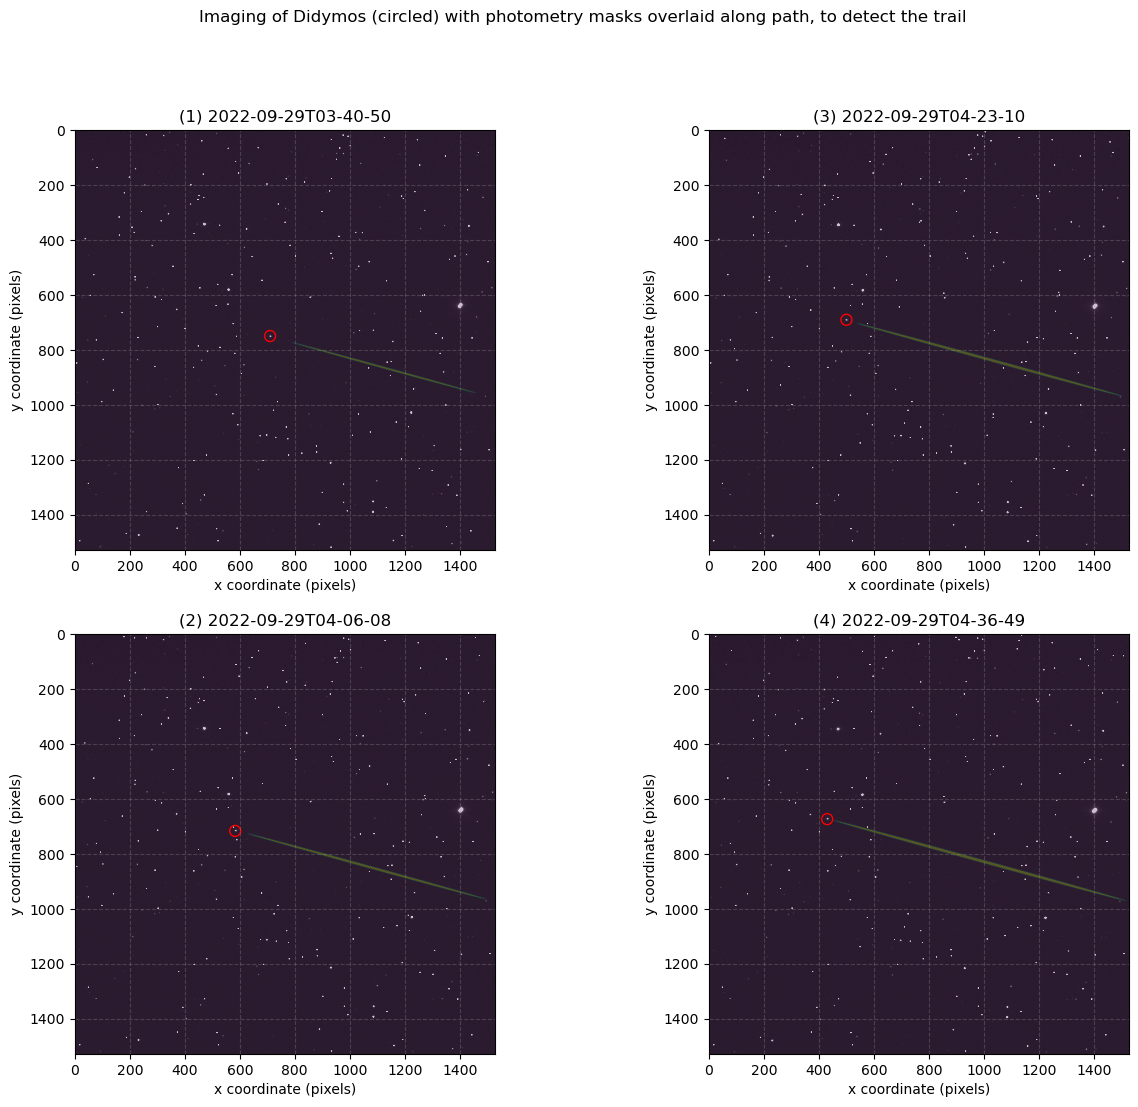

In [34]:
### adapted from task 4 submission like initial ap() function ###

def ap_trail(subset, r, x_cutoff):
    """
    Performs aperture photometry using an elliptical aperture along the path
    of Didymos, on the given subset (or full image), using:
    subset: input data
    r: aperture thickness
    x_cutoff: coordinate just before Didymos to ensure it isn't
              included in the aperture
        
    The function returns the aperture mask, and calculated flux.
    """
    size=np.shape(subset)[0]

    # The following creates a size^2 array from "0" to "size" and then rearranges it 
    # so its counting along columns and then up 1 row at a time
    temp = np.linspace(0,size,size*size)

    # We then use the "reshape" command to rearrange this long 1D array of values to make a square array
    temp2 = np.reshape(temp,(size,size))

    # Now we use the raster scan array obtained to create two arrays which are respectively the "x" and the "y" of 
    # any 2D square image we want with "size" as its side.

    yy = np.floor(temp2)     # floor truncates the array (as pixel values are integers)
    temp3 = size*(temp2-yy)
    xx = np.floor(temp3)
    
    # straight line fit for centre of aperture
    m_ap, c_ap = np.polyfit(x_pix_didy,y_pix_didy,degree,cov='unscaled')[0]
    x_ap = np.linspace(x_cutoff,1525,10001)
    y_ap = m_ap * x_ap + c_ap
    
    # for ellipse, need angle offset
    k = np.arctan(m_ap)
    
    # transformed X,Y incl angle. eqns 11.2, 11.3
    X = (xx-np.median(x_ap))*np.cos(k)+(yy-np.median(y_ap))*np.sin(k)
    Y = -(xx-np.median(x_ap))*np.sin(k)+(yy-np.median(y_ap))*np.cos(k)
    
    #radius of aperture as function, eqn 11.1
    radius1 = np.sqrt(X**2 /np.sqrt((len(x_ap))**2) + Y**2)

    #mask as radius function limited to below r defined above
    mask1 = radius1 <= r

    #an annulus here would be so large and likely contain several background stars,
    #so I've opted to use the whole image background instead
    median, err_an = back_lvl(subset)

    #flux using eqn 1
    flux = np.sum(subset*mask1) - np.sum(mask1) * median
    
    #aperture error can be approximated as sqrt(flux) due to Poissonian nature
    err_ap = np.sqrt(flux)
    
    err_flux = np.sqrt(err_ap**2 + err_an**2)

    return mask1, flux, err_flux


#####


#configuring subplots
fig, ax = plt.subplots(2,2)

for i in range(2):
    for j in range(2):        
        ax[i,j].grid(linestyle='--', alpha=0.25)
        ax[i,j].set_xlabel('x coordinate (pixels)')
        ax[i,j].set_ylabel('y coordinate (pixels)')

plt.suptitle('Imaging of Didymos (circled) with photometry masks overlaid along path, to detect the trail')
# upper left
ax[0,0].set_title('(1) 2022-09-29T03-40-50')
quicksubplot(data1, 0.5,3,0,0)
ax[0,0].imshow(ap_trail(data1,3.5,x_d1+r)[0], alpha=0.25)
ax[0,0].add_patch(plt.Circle((x_d1,y_d1),20, color='r', fill=False))

#lower left
ax[1,0].set_title('(2) 2022-09-29T04-06-08')
quicksubplot(data2, 0.5,3,1,0)
ax[1,0].imshow(ap_trail(data2,4.5,x_d2+r)[0], alpha=0.25)
ax[1,0].add_patch(plt.Circle((x_d2,y_d2),20, color='r', fill=False))

#upper right
ax[0,1].set_title('(3) 2022-09-29T04-23-10')
quicksubplot(data3, 0.5,3,0,1)
ax[0,1].imshow(ap_trail(data3,5,x_d3+r)[0], alpha=0.25)
ax[0,1].add_patch(plt.Circle((x_d3,y_d3),20, color='r', fill=False))

#lower right
ax[1,1].set_title('(4) 2022-09-29T04-36-49')
quicksubplot(data4, 0.5,3,1,1)
ax[1,1].imshow(ap_trail(data4,5.5,x_d4+r)[0], alpha=0.25)
ax[1,1].add_patch(plt.Circle((x_d4,y_d4),20, color='r', fill=False))

<center> Fig. 12: Imaging of Didymos (circled) with photometry masks overlaid along Didymos`s previous path, to detect the trail </center>

In [35]:
# fluxes from above photometry
mask_t1, f_trail1, err_f_trail1 = ap_trail(data1,3.5,x_d1+r)
mask_t2, f_trail2, err_f_trail2 = ap_trail(data2,4.5,x_d2+r)
mask_t3, f_trail3, err_f_trail3 = ap_trail(data3,5,x_d3+r)
mask_t4, f_trail4, err_f_trail4 = ap_trail(data4,5.5,x_d4+r)

# into arrays for easier calculations
f_trail = np.array([f_trail1,f_trail2,f_trail3,f_trail4])
err_f_trail = np.array([err_f_trail1,err_f_trail2,err_f_trail3,err_f_trail4])

print('Raw fluxes of the trail in each image (total values):')
for i in range(4):
    print(f"{i+1}: {f_trail[i]:.0f} +- {err_f_trail[i]:.0f} ADUs")

Raw fluxes of the trail in each image (total values):
1: 85991 +- 294 ADUs
2: 152055 +- 390 ADUs
3: 185323 +- 431 ADUs
4: 227705 +- 478 ADUs


As expected, these fluxes vary such that the larger apertures have greater fluxes. These haven't been detrended yet, as they need to first be converted into counts per unit angle to get a more accurate trend. To do this, I've used `np.where(mask_t#)[0]` which returns all the y positions located within the mask. This is useful as I can now pinpoint the apoapsis/periapsis of the ellipses, to use to calculate the angles the ellipses cover.

In [36]:
print(np.where(mask_t1)[0])
print(np.where(mask_t2)[0])
print(np.where(mask_t3)[0])
print(np.where(mask_t4)[0])

[772 772 772 ... 956 956 956]
[728 728 728 ... 965 965 965]
[703 703 703 ... 967 967 967]
[680 680 680 ... 970 971 971]


Next is converting these pixel coordinates to RA and Dec using my `pix2cel()` function, and then calculating the angles the ellipses cover. This is where I now detrend the fluxes, as they now are representative of the flux over time.

In [37]:
#printed minima and maxima above into arrays,
# representing the extremes of the ellipses
y_left = np.array([772,728,703,680])
y_right = np.array([956,965,967,971])

# recovering m_ap, c_ap for use outside the ap_trail() function
m_ap, c_ap = np.polyfit(x_pix_didy,y_pix_didy,degree,cov='unscaled')[0]

#retrieving x positions of the extremes
x_left = (y_left - c_ap)/m_ap
x_right = (y_right - c_ap)/m_ap

#converting to ra, dec
ra_left1, dec_left1 = pix2cel(x_left[0],y_left[0],head1)
ra_right1, dec_right1 = pix2cel(x_right[0],y_right[0],head1)
#change in ra, dec over the ellipse
d_ra1 = ra_right1 - ra_left1
d_dec1 = dec_right1 - dec_left1

#repeat for other three frames
#(not a loop as the headers are separate)
ra_left2, dec_left2 = pix2cel(x_left[1],y_left[1],head2)
ra_right2, dec_right2 = pix2cel(x_right[1],y_right[1],head2)
d_ra2 = ra_right2 - ra_left2
d_dec2 = dec_right2 - dec_left2

ra_left3, dec_left3 = pix2cel(x_left[2],y_left[2],head3)
ra_right3, dec_right3 = pix2cel(x_right[2],y_right[2],head3)
d_ra3 = ra_right3 - ra_left3
d_dec3 = dec_right3 - dec_left3

ra_left4, dec_left4 = pix2cel(x_left[3],y_left[3],head4)
ra_right4, dec_right4 = pix2cel(x_right[3],y_right[3],head4)
d_ra4 = ra_right4 - ra_left4
d_dec4 = dec_right4 - dec_left4

#into arrays for convenience
d_ra = np.array([d_ra1,d_ra2,d_ra3,d_ra4])
d_dec = np.array([d_dec1,d_dec2,d_dec3,d_dec4])

# more arrays for convenience
d_ang = np.zeros(4)
f_trail_per_sec = np.zeros(4)
err_f_trail_per_sec = np.zeros(4)

print('Detrended fluxes of the trail in each image (per arcsecond):')

# change in angle over the sky in arcsecs
for i in range(4):
    d_ang[i] = np.sqrt(d_dec[i]**2 + d_ra[i]**2 * np.cos(delta)**2) * 3600

# now dividing the fluxes by the range the ellipse covers in arcsecs
    f_trail_per_sec[i] = f_trail[i] / d_ang[i]
    err_f_trail_per_sec[i] = err_f_trail[i] / d_ang[i]
    
# finding residuals from mean trend curve and normed fluxes
resid_trail = f_trail_per_sec/np.max(f_trail_per_sec) - y_mean_frames

# detrending the initial fluxes by correcting for gains. background noise
# isn't included here as I used it in the ap_trail() function
f_trail_detr_per_sec = f_trail_per_sec / y_mean_frames

# error propagation: eqn 4
err_f_trail_detr_per_sec = f_trail_detr_per_sec*np.sqrt((err_f_trail_per_sec**2/f_trail_per_sec**2 + resid_trail**2/y_mean_frames**2))

for i in range(4):    
    print(f"{i+1}: {f_trail_detr_per_sec[i]:.0f} +- {err_f_trail_detr_per_sec[i]:.0f} ADUs/arcsec")

Detrended fluxes of the trail in each image (per arcsecond):
1: 107 +- 40 ADUs/arcsec
2: 144 +- 22 ADUs/arcsec
3: 155 +- 14 ADUs/arcsec
4: 177 +- 7 ADUs/arcsec


These detrended fluxes appear much more suitable for comparison now. Next I plot these as a function of time, like previously done for Didymos.

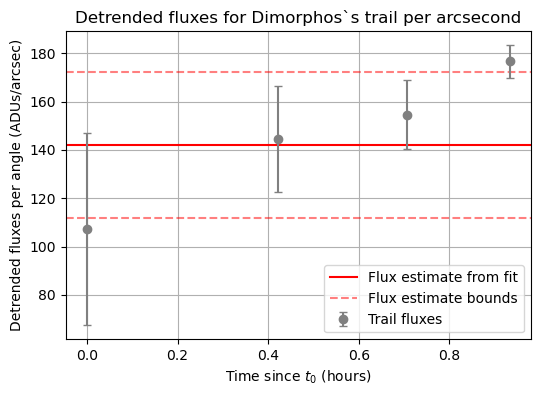

In [38]:
# straight line fit as done a few times already
params_f_trail, cov_f_trail = np.polyfit(obs_t,f_trail_detr_per_sec,degree,cov='unscaled', w=1/err_f_trail_detr_per_sec)
m_f_trail, c_f_trail = params_f_trail
err_m_f_trail, err_c_f_trail = np.sqrt(np.diag(cov_f_trail))
y_f_trail = m_f_trail * x_trend + c_f_trail  # calculate corresponding y values

#taking the average of the fit line, as it is a strong assumption that
#the photometry was constant over this brief time interval.
#this leaves a horizontal line, where upper & lower limits can be
#applied using the error from the fit
flux_trail_avg = np.mean(y_f_trail)

#plotting everything incl estimate (& bounds)
plt.figure(figsize=(6,4))
plt.grid()
plt.title('Detrended fluxes for Dimorphos`s trail per arcsecond')
plt.xlabel('Time since $t_0$ (hours)')
plt.ylabel('Detrended fluxes per angle (ADUs/arcsec)')
plt.axhline(flux_trail_avg,color='r', label='Flux estimate from fit')
plt.axhline(flux_trail_avg+err_m_f_trail,color='r', linestyle='--', label='Flux estimate bounds', alpha=0.5)
plt.axhline(flux_trail_avg-err_m_f_trail,color='r', linestyle='--', alpha=0.5)
plt.errorbar(obs_t, f_trail_detr_per_sec, yerr=err_f_trail_detr_per_sec, fmt='o',capsize=3, label = 'Trail fluxes',color='gray')
plt.legend(loc='best')

<center> Fig. 13: Plot of the detrended fluxes for Dimorphos`s trail per arcsecond </center>

In [39]:
print(f'The average detrended flux of Dimorphos`s trail from the fit is {flux_trail_avg:.0f} +- {err_m_f_trail:.0f} ADUs/arcsec')

The average detrended flux of Dimorphos`s trail from the fit is 142 +- 30 ADUs/arcsec


Having plotted the flux per arcsecond against time, it is clear that the trail is measureable, although it is very faint. What is interesting is that from the plot it appears that the flux increases over time, however I believe that due to the fourth data point having the largest aperture there may be some contamination from faint background stars that has had a more prominent effect.

$$-*-$$

## Conclusion

In conclusion, the magnitude of the Didymos system was calculated to be 12.92 $\pm$ 0.08, which is in agreement with the calculated value by A. Graykowski _et al._ of $m_v$ = 12.96 $\pm$ 0.04, for a similar time of observation, once the fast-moving ejecta was no longer in the aperture <a href="https://www.nature.com/articles/s41586-023-05852-9">[1]</a>. Even though there is a difference in filters (as from <a href="https://www.nature.com/articles/s41586-023-05852-9">[1]</a> is in the Visual band) it suggests Didymos has a constant brightness over the Visual and Red bands. This brightness was found to drop to an estimated 96.1% when Dimorphos transits Didymos. In addition, the angular velocity of Didymos was calculated as 0.105 $\pm$ 1.411 $^{\circ}$/hr. The recorded value from the JPL Ephemeris service <a href="https://ssd.jpl.nasa.gov/horizons/app.html#/">[2]</a> is 0.107 $^{\circ}$/hr, which lies within the (large!) uncertainty. Even discounting the large uncertainty, the actual value is a 2% difference to the calculated value, suggesting some accuracy. Finally, photometry using an elliptical aperture led to a calculation of the flux of the trail from the DART impact on Dimorphos as 140 $\pm$ 30 ADUs/arcsec, which is very faint but still a noticeable signal.

## References


[1] "Light curves and colours of the ejecta from Dimorphos after the DART impact", Graykowski, A. _et al._ (2023). Available at https://www.nature.com/articles/s41586-023-05852-9 (accessed 3 Mar 2024)

[2] JPL Ephemeris service https://ssd.jpl.nasa.gov/horizons/app.html#/ (accessed 27 Feb 2024)  

[3] "Median" on Wikipedia https://en.wikipedia.org/wiki/Median#Efficiency (accessed 28 Feb 2024)  

[4] "PHAS0020 pre-sessions basics revision (C)", Fossey, S. _et al._ (revised ver. 2023). Available from the PHAS0020 Moodle page under 'First half of Term 2: Computing with Python' as 'PHAS0020-S0c-JupyterN_PHAS0003-refresh.ipynb'. (accessed 21 Feb 2024)  

[5] AladinLite https://aladin.cds.unistra.fr/AladinLite/ (accessed 27 Feb 2024)  

[6] "Fitting a Function to Data", Waugh, B. (2022). Available from the PHAS0007 Experimental Physics Moodle page as 'FittingAFunctionToData(14.11.2022).ipynb'. (accessed 21 Feb 2024)  

[7] "Data Analysis and Statistics Booklet", Szumilo, M. _et al._ (2022). Available from the PHAS0020 Moodle page under 'Data Analysis Lectures and Problem Sheet' as 'Data Analysis and Statistics Booklet (Yr1) (2022 update)'. (accessed 2 Mar 2024)  

[8] "Proper Motion" on Wikipedia https://en.wikipedia.org/wiki/Proper_motion (accessed 29 Feb 2024)  

[9] "65803 Didymos" on Wikipedia https://en.wikipedia.org/wiki/65803_Didymos (accessed 3 Mar 2024)  

[10] "Dimorphos Orbit Determination from Mutual Events Photometry", Scheirich, P. _et al._ (2024). Available at https://iopscience.iop.org/article/10.3847/PSJ/ad12cf (accessed 3 Mar 2024)  

[11] "CHI-1, 60CM F6.5 REFLECTOR" on Telescope Live, under "CCD Camera Specification (CHI-1-CCD, discontinued in Jan 2023) https://help.telescope.live/hc/en-us/articles/360002557197-CHI-1-60cm-F6-5-Reflector (accessed 2 Mar 2024)  

[12] "NASA’s DART Mission Hits Asteroid in First-Ever Planetary Defense Test" (2022). Available at https://www.nasa.gov/news-release/nasas-dart-mission-hits-asteroid-in-first-ever-planetary-defense-test/ (accessed 3 Mar 2024)  

[13] "Ellipse" on Wikipedia https://en.wikipedia.org/wiki/Ellipse (accessed 3 Mar 2024)  